In [77]:

from experiment_information import *
from data import *
from helpers import *
from _version import __version__
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import logging
import pprint
%load_ext autoreload
%autoreload 2

import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 1
mpl.rcParams['legend.fontsize'] = 13

mpl.rcParams['axes.titlesize'] = 15
mpl.rcParams['axes.labelsize'] = 13
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [78]:

from _version import __version__
df_experiments = None
df_state_evolution = None
df_erm = None
logger = logging.getLogger()
with DatabaseHandler(logger,"experiments/experiments.db") as dbHandler:
    df_experiments = dbHandler.get_experiments()
    df_state_evolution = dbHandler.get_state_evolutions()
    df_state_evolution["calibrations"] = df_state_evolution["calibrations"].apply(lambda x: json.loads(x))
    df_erm = dbHandler.get_erms()
    df_erm["analytical_calibrations"] = df_erm["analytical_calibrations"].apply(lambda x: json.loads(x))
    df_erm["erm_calibrations"] = df_erm["erm_calibrations"].apply(lambda x: json.loads(x))
    # delete incomplete experiments (bad, deletes running experiments...)
    # dbHandler.delete_incomplete_experiments()

# def explode_calibrations(df):
#     a = df["calibrations"].apply(pd.Series)
#     # drop the original calibrations column
#     df = df.drop(columns=["calibrations"])
#     # concat the original dataframe with the new dataframe containing the exploded calibrations column
#     df = pd.concat([df,a],axis=1)
#     # explode both calibrations and ps columns
#     df = df.explode(["calibrations","ps"])
#     # rename the exploded columns
#     df = df.rename(columns={"calibrations":"calibration","ps":"p_calibration"})
#     return df
# df_state_evolution = explode_calibrations(df_state_evolution)
# def explode_erm_calibrations(df):
#     a = df["erm_calibrations"].apply(pd.Series)
#     # drop the original calibrations column
#     df = df.drop(columns=["erm_calibrations"])
#     b = df["analytical_calibrations"].apply(pd.Series)
#     # drop the original calibrations column
#     df = df.drop(columns=["analytical_calibrations"])
#     # drop the dp and ps columns from b
#     b = b.drop(columns=["dp","ps"])
#     # rename the columns of b
#     b = b.rename(columns={"calibrations":"analytical_calibration"})
#     # rename the columns of a
#     a = a.rename(columns={"calibrations":"erm_calibration"})
#     # concat the original dataframe with the new dataframe containing the exploded calibrations column
#     df = pd.concat([df,a],axis=1)
#     df = pd.concat([df,b],axis=1)
#     # explode both calibrations and ps columns
#     df = df.explode(["erm_calibration","analytical_calibration","ps"])
#     # rename the exploded columns
#     df = df.rename(columns={"ps":"p_calibration"})
#     return df
# df_erm = explode_erm_calibrations(df_erm)

def explode_measures(df, new_columns, columns):
    for column in columns:
        def transform(column):
            # replace NaN in the column string by 0
            column = column.replace("NaN","0")
            return eval(column)
        df[column] = df[column].apply(transform)

    exploded = df.explode(columns).reset_index(drop=True)

    for new_column, column in zip(new_columns, columns):
        exploded[["attack_epsilon",new_column]] = pd.DataFrame(exploded[column].tolist(), index=exploded.index)

    exploded = exploded.drop(columns=columns)
    return exploded

def explode_erm_measures(df):
    columns = ["adversarial_generalization_errors","adversarial_generalization_errors_teacher","adversarial_generalization_errors_overlap","fair_adversarial_errors","test_losses"]
    new_columns = ["adversarial_generalization_error","adversarial_generalization_error_teacher","adversarial_generalization_error_overlap","fair_adversarial_error","test_loss"]
    return explode_measures(df, new_columns, columns)

def explode_state_evolution_measures(df):
    columns = ["adversarial_generalization_errors","adversarial_generalization_errors_teacher","fair_adversarial_errors","test_losses"]
    new_columns = ["adversarial_generalization_error","adversarial_generalization_error_teacher","fair_adversarial_error","test_loss"]
    return explode_measures(df, new_columns, columns)
    
df_erm = explode_erm_measures(df_erm)
df_state_evolution = explode_state_evolution_measures(df_state_evolution)
    

print("Current code version, ", __version__)

Current code version,  87


In [79]:
# get the completed experiments with the current code version ordered by date
version_choice = __version__
# version_choice = "68"
df_experiments = df_experiments[(df_experiments["completed"]==True) & (df_experiments["code_version"]==version_choice)]
df_experiments = df_experiments.sort_values(by="date",ascending=False)
df_experiments.head(3)

experiment_id  \
2  8d447da3-bb9f-4af8-aaeb-f55913a72df4   
1  b718b141-5991-4d5e-b01f-292648bf9fa7   
0  d5e2ffc7-9584-493c-a3c1-528c56128cb2   

                                     experiment_name    duration  \
2  Sweep Alpha - KFeaturesModel - KFeaturesModel_...  122.496983   
1  Sweep Alpha - KFeaturesModel - KFeaturesModel_...  109.444848   
0  Sweep Alpha - KFeaturesModel - KFeaturesModel_...  147.578456   

  problem_types code_version                 date  \
2  ["Logistic"]           87  2023-11-28 17:36:13   
1  ["Logistic"]           87  2023-11-28 17:26:56   
0  ["Logistic"]           87  2023-11-28 17:12:45   

   state_evolution_repetitions  erm_repetitions         alphas    epsilons  \
2                            1                2  [0.1585, 1.0]  [0.0, 0.4]   
1                            1                2  [0.1585, 1.0]  [0.0, 0.4]   
0                            1                2  [0.1585, 1.0]  [0.0, 0.4]   

   ...    taus    ps    dp     d  experiment_type  completed data_model_type  \
2  ...  [0, 1]  null  0.01  1000            Sweep          1  KFeaturesModel   
1  ...  [0, 1]  null  0.01  1000            Sweep          1  KFeaturesModel   
0  ...  [0, 1]  null  0.01  1000            Sweep          1  KFeaturesModel   

                                     data_model_name  \
2  KFeaturesModel_TwoFeatures_ProtectingSecondHal...   
1  KFeaturesModel_TwoFeatures_ProtectingSecondHal...   
0  KFeaturesModel_TwoFeatures_ProtectingSecondHal...   

                              data_model_description gamma_fair_error  
2  2 Features, Theta Identity, Sigma_upsilon Iden...             0.01  
1  2 Features, Theta Identity, Sigma_upsilon Iden...             0.01  
0  2 Features, Theta Identity, Sigma_upsilon Iden...             0.01  

[3 rows x 22 columns]

In [80]:
df_state_evolution["estimation_error"] = 1 + df_state_evolution["q"] - 2 * df_state_evolution["m"]

In [81]:
experiment_loc = 0

# extract and print the top experiment_id
experiment_id = df_experiments.iloc[experiment_loc]["experiment_id"]
print(experiment_id)

# extract and print the experiment type
experiment_type = df_experiments.iloc[experiment_loc]["experiment_type"]
print(experiment_type)

# extract and print the data model type and data_model name used
data_model_type = df_experiments.iloc[experiment_loc]["data_model_type"]
# convert it to the enum
data_model_type = DataModelType[data_model_type]
data_model_name = df_experiments.iloc[experiment_loc]["data_model_name"]
data_model_description = df_experiments.iloc[experiment_loc]["data_model_description"]
print(data_model_type.name, data_model_name)
print(data_model_description)

# print the experiment name
experiment_name = df_experiments.iloc[experiment_loc]["experiment_name"]
print(experiment_name)

# print the experiment problem types
experiment_problem_types = df_experiments.iloc[experiment_loc]["problem_types"]
experiment_problem_types = json.loads(experiment_problem_types)
print(experiment_problem_types)

8d447da3-bb9f-4af8-aaeb-f55913a72df4
Sweep
KFeaturesModel KFeaturesModel_TwoFeatures_ProtectingSecondHalf_AttackingIdentity_[0.5 0.5]_[10  1]_[1 1]_SD_1_10_SU_1_10
2 Features, Theta Identity, Sigma_upsilon Identity, Sigma_delta 10*Identity for the second half of the features
Sweep Alpha - KFeaturesModel - KFeaturesModel_TwoFeatures_ProtectingSecondHalf_AttackingIdentity_[0.5 0.5]_[10  1]_[1 1]_SD_1_10_SU_1_10 - 2 Features, Theta Identity, Sigma_upsilon Identity, Sigma_delta 10*Identity for the second half of the features
['Logistic']


In [82]:
state_evolution = df_state_evolution[df_state_evolution["experiment_id" ] == experiment_id]
erm = df_erm[df_erm["experiment_id" ] == experiment_id]
gd = erm[erm["chosen_minimizer"] == "sklearn"]
# make the column subspace_overlaps to string
state_evolution["subspace_overlaps"] = state_evolution["subspace_overlaps"].apply(lambda x: str(x))
gd["subspace_overlaps"] = gd["subspace_overlaps"].apply(lambda x: str(x))
# create a json colum
state_evolution["subspace_overlaps"] = state_evolution["subspace_overlaps"].apply(lambda x: json.loads(x))
gd["subspace_overlaps"] = gd["subspace_overlaps"].apply(lambda x: json.loads(x))
from pandas import json_normalize
# normalize the json column
normalized = json_normalize(state_evolution["subspace_overlaps"])
normalized_gd = json_normalize(gd["subspace_overlaps"])


def explode_array_column(row, col):
    return pd.Series(row[col])

# reset the index of the original dataframe
state_evolution = state_evolution.reset_index(drop=True)
gd = gd.reset_index(drop=True)

for col in normalized.columns:
    expanded_cols = normalized.apply(lambda x: explode_array_column(x,col), axis=1)
    col = col[:-1]
    expanded_cols.columns = [col+'_{}'.format(i) for i in range(expanded_cols.shape[1])]
    # reset the index of the expanded columns
    expanded_cols = expanded_cols.reset_index(drop=True)
    state_evolution = pd.concat([state_evolution, expanded_cols], axis=1)

for col in normalized_gd.columns:
    expanded_cols = normalized_gd.apply(lambda x: explode_array_column(x,col), axis=1)
    col = col[:-1]
    expanded_cols.columns = [col+'_{}'.format(i) for i in range(expanded_cols.shape[1])]
    # reset the index of the expanded columns
    expanded_cols = expanded_cols.reset_index(drop=True)

    gd = pd.concat([gd, expanded_cols], axis=1)

/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50464/2419844444.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  state_evolution["subspace_overlaps"] = state_evolution["subspace_overlaps"].apply(lambda x: str(x))
/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50464/2419844444.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  state_evolution["subspace_overlaps"] = state_evolution["subspace_overlaps"].apply(lambda x: json.loads(x))


In [83]:
gd = gd.set_index(["alpha","epsilon","tau","lam","problem_type","attack_epsilon"]) #,"p_calibration"
state_evolution = state_evolution.set_index(["alpha","epsilon","tau","lam","problem_type","attack_epsilon"]) #,"p_calibration"

# drop id, code_version, experiment_id, date, initial_condition, test_against_epsilons, calibrations, abs_tol, min_iter,max_iter,blend_fpe,int_lims,subspace_overlaps
state_evolution = state_evolution.drop(columns=["id","code_version","experiment_id","date","initial_condition","test_against_epsilons","calibrations","abs_tol","min_iter","max_iter","blend_fpe","int_lims","subspace_overlaps"])
# drop id, code_version, experiment_id, test_against_epsilons, date, chosen_minimizer, subspace_overlaps, analytical_calibrations, erm_calibrations, 
gd = gd.drop(columns=["id","code_version","experiment_id","test_against_epsilons","date","chosen_minimizer","subspace_overlaps","analytical_calibrations","erm_calibrations"])

state_evolution.columns = [col+"_state_evolution" for col in state_evolution.columns]
gd.columns = [col+"_erm" for col in gd.columns]

state_evolution = state_evolution.groupby(level=[0,1,2,3,4,5]).agg(["mean","std"]) #,4
gd = gd.groupby(level=[0,1,2,3,4,5]).agg(["mean","std"]) #,4
df = state_evolution.join(gd, how="outer")
df.sort_index()
df

duration_state_evolution  \
                                                                         mean   
alpha  epsilon tau lam   problem_type attack_epsilon                            
0.1585 0.0     0.0 0.001 Logistic     0.0                            1.550322   
                                      0.2                            1.550322   
                                      0.4                            1.550322   
                                      0.6                            1.550322   
               1.0 0.001 Logistic     0.0                            1.547505   
                                      0.2                            1.547505   
                                      0.4                            1.547505   
                                      0.6                            1.547505   
       0.4     0.0 0.001 Logistic     0.0                            2.155578   
                                      0.2                            2.155578   
                                      0.4                            2.155578   
                                      0.6                            2.155578   
               1.0 0.001 Logistic     0.0                            0.488715   
                                      0.2                            0.488715   
                                      0.4                            0.488715   
                                      0.6                            0.488715   
1.0000 0.0     0.0 0.001 Logistic     0.0                            0.369626   
                                      0.2                            0.369626   
                                      0.4                            0.369626   
                                      0.6                            0.369626   
               1.0 0.001 Logistic     0.0                            0.534088   
                                      0.2                            0.534088   
                                      0.4                            0.534088   
                                      0.6                            0.534088   
       0.4     0.0 0.001 Logistic     0.0                            1.644299   
                                      0.2                            1.644299   
                                      0.4                            1.644299   
                                      0.6                            1.644299   
               1.0 0.001 Logistic     0.0                            2.293228   
                                      0.2                            2.293228   
                                      0.4                            2.293228   
                                      0.6                            2.293228   

                                                          \
                                                     std   
alpha  epsilon tau lam   problem_type attack_epsilon       
0.1585 0.0     0.0 0.001 Logistic     0.0            NaN   
                                      0.2            NaN   
                                      0.4            NaN   
                                      0.6            NaN   
               1.0 0.001 Logistic     0.0            NaN   
                                      0.2            NaN   
                                      0.4            NaN   
                                      0.6            NaN   
       0.4     0.0 0.001 Logistic     0.0            NaN   
                                      0.2            NaN   
                                      0.4            NaN   
                                      0.6            NaN   
               1.0 0.001 Logistic     0.0            NaN   
                                      0.2            NaN   
                                      0.4            NaN   
                                      0.6            NaN   
1.0000 0.0     0.0 0.001 Logistic     0.0            NaN   
                 

In [84]:
optimal_lambdas = load_csv_to_object_dictionary(OptimalLambdaResult(0,0,0,0,None,None,None),path="experiments/")
def extract_optimal_lambda(alpha, epsilon, tau, data_model_type, data_model_name, problem_type):
    # extract or compute optimal lamba and plot it as a vertical line
    optimal_result = OptimalLambdaResult(alpha,epsilon,tau,1,data_model_type,data_model_name, problem_type)
    if optimal_result.get_key() in optimal_lambdas:
        optimal_lambda = optimal_lambdas[optimal_result.get_key()]
        return optimal_lambda
    else:   
        print("Optimal lambda not found for ", optimal_result.get_key())
        return None
    

In [85]:
first_iteration = "tau"
second_iteration = None #"lam" # "lam"
target = "alpha"
sweep = "epsilon"
save_plots = False
description = ""

def get_path(problem_type, filename = None):
    # make sure the directory for the data_model_name exists
    directory = f"Assets/{data_model_name}"
    if not os.path.exists(directory):
        os.makedirs(directory)

    # encode the sweep type as a directory
    sweep_name = f"x_{target}_different_{sweep}_many_{second_iteration}"
    directory = f"Assets/{data_model_name}/{sweep_name}"
    if not os.path.exists(directory):
        os.makedirs(directory)

    # encode the problem type as a directory
    directory = f"Assets/{data_model_name}/{sweep_name}/{problem_type}"
    if not os.path.exists(directory):
        os.makedirs(directory)

    if filename is None:
        filename = description
    
    directory = f"Assets/{data_model_name}/{sweep_name}/{problem_type}/{filename}/"
    if not os.path.exists(directory):
        os.makedirs(directory)
    
    return f"Assets/{data_model_name}/{sweep_name}/{problem_type}/{filename}/"

def create_plot(df, error_name, state_evolution_name, gd_name, log_x = True, log_y=True, fix_a_variable = None, variable_value = None, filename=None, plot_attack_epsilon=False):
    df2 = df.reset_index()
    df2.sort_index()
    # Define a color palette to use for the different epsilon values
    palette = sns.color_palette(n_colors=len(df2[sweep].unique()))

    d = df2['d_erm']["mean"][0]

    attack_epsilons = df2["attack_epsilon"].unique()
    if not plot_attack_epsilon:
        # assign just the first attack_epsilon
        attack_epsilons = [attack_epsilons[0]]

    for attack_epsilon in attack_epsilons:

        for problem_type in df2["problem_type"].unique():

            for tau in df2[first_iteration].unique():

                iterate_over = df2[second_iteration].unique() if second_iteration is not None else [None]

                for lam in iterate_over:

                    fig = plt.figure()
                    ax = plt.subplot(111)

                    # Filter the dataframe for the current values of tau and lam
                    if second_iteration is None:
                        data = df2[(df2[first_iteration] == tau) & (df2["problem_type"] == problem_type) & (df2["attack_epsilon"] == attack_epsilon)]
                    else:
                        data = df2[(df2[first_iteration] == tau) & (df2[second_iteration] == lam) & (df2["problem_type"] == problem_type) & (df2["attack_epsilon"] == attack_epsilon)]

                    if fix_a_variable is not None:
                        data = data[data[fix_a_variable] == variable_value]
                    
                    for i, epsilon in enumerate(data[sweep].unique()):
                        # Filter the dataframe for the current value of epsilon
                        epsilon_subset = data[data[sweep] == epsilon]

                        # Plot the state_evolution results as a line
                        if state_evolution_name is not None:
                            if state_evolution_name in ["alpha","tau","lam","epsilon"]:
                                ax.plot(epsilon_subset[target], epsilon_subset[(state_evolution_name)], label=f'{sweep}: {epsilon:.4f}', color=palette[i])
                            else:
                                ax.plot(epsilon_subset[target], epsilon_subset[(state_evolution_name, 'mean')], label=f'{sweep}: {epsilon:.4f}', color=palette[i])
                        
                        # Plot the gradient_descent results as points with error bars
                        if gd_name is not None:
                            try:
                                ax.errorbar(epsilon_subset[target], epsilon_subset[(gd_name, 'mean')], yerr=epsilon_subset[(gd_name, 'std')], fmt='o', color=palette[i], capsize=5)
                            except:
                                pass

                        if error_name == "Generalization Error" and target == "lam":
                            optimal_lambda = extract_optimal_lambda(alpha=lam, epsilon=epsilon, tau=tau, data_model_type=data_model_type, data_model_name=data_model_name, problem_type=ProblemType[problem_type])
                            # plot the optimal lambda as a vertical line
                            if optimal_lambda is not None:
                                ax.axvline(x=optimal_lambda, color=palette[i], linestyle='--')

                    
                    if log_x:
                        plt.xscale('log')
                        # plt.xscale('symlog')
                    if log_y:
                        plt.yscale('log')

                    # Add labels and title
                    plt.xlabel(target)
                    plt.ylabel(error_name)
                    title = f"{error_name} - {problem_type} - {first_iteration}: {tau},"
                    if fix_a_variable is not None:
                        if second_iteration is None:
                            title += f' d: {d} - {fix_a_variable}: {variable_value}'
                        else:
                            title += f' {second_iteration}: {lam}, d: {d} - {fix_a_variable}: {variable_value}'
                    else:
                        if second_iteration is None:
                            title += f' d: {d}'
                        else:
                            title += f' {second_iteration}: {lam}, d: {d}'
                    if plot_attack_epsilon:
                        title += f" - attack_epsilon: {attack_epsilon}"
                    plt.title(title,y=1.1)
                    

                    box = ax.get_position()
                    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

                    # Put a legend to the right of the current axis
                    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

                    # add a grid
                    plt.grid()

                    plt.tight_layout()

                    if fix_a_variable is not None:
                        name = f"{error_name}_{problem_type}_{data_model_name}_tau_{tau}_lam_{lam}_d_{d}_{fix_a_variable}_{variable_value}_v_{__version__}"
                    else:
                        name = f"{error_name}_{problem_type}_{data_model_name}_tau_{tau}_lam_{lam}_d_{d}_v_{__version__}"
                    if plot_attack_epsilon:
                        name += f"_attack_epsilon_{attack_epsilon}"
                    # Save the plot as svg
                    if filename is not None or save_plots:


                        path = get_path(problem_type, filename)

                        plt.savefig(f"{path}_{name}.pdf", bbox_inches='tight')

                    # Show the plot
                    plt.show()


In [86]:
# Write some code to store all information about the data_model in a json file next to all the plots
if save_plots:
    for problem_type in experiment_problem_types:
        path = get_path(problem_type)

        # get an ExperimentInformation object from one entry in df_experiments
        experiment = ExperimentInformation.from_df(df_experiments.iloc[experiment_loc])

        # load the data_model and store it in a dictionary
        data_model = experiment.get_data_model(logger,source_pickle_path="", name = experiment.data_model_name)
        data_model_dict = data_model.__dict__
        # remove the logger from the dictionary
        del data_model_dict["logger"]
        # add the code version to the dictionary
        data_model_dict["code_version"] = __version__
        # add the experiment_id to the dictionary
        data_model_dict["experiment_id"] = experiment_id
        # add the experiment_name to the dictionary
        data_model_dict["experiment_name"] = experiment_name
        # add the experiment_problem_types to the dictionary
        data_model_dict["experiment_problem_types"] = experiment_problem_types
        # add the experiment_type to the dictionary
        data_model_dict["experiment_type"] = experiment_type

        # remove all _abc_data
        for key in list(data_model_dict.keys()):
            if "_abc" in key:
                del data_model_dict[key]
            
        # remove all methods
        for key in list(data_model_dict.keys()):
            if callable(data_model_dict[key]):
                del data_model_dict[key]

        

        # store the dictionary as a json file
        with open(f"{path}_data_model.json", 'w') as fp:
            pp = pprint.PrettyPrinter(indent=4)
            text = pp.pformat(data_model_dict)
            fp.write(text)
            

In [87]:
# create_plot(df, "Calibration", "calibration_state_evolution","erm_calibration_erm",fix_a_variable="alpha", variable_value=1.0)
# create_plot(df, "Calibration", "calibration_state_evolution","erm_calibration_erm",fix_a_variable="alpha", variable_value=2.0)
# create_plot(df, "Calibration", "calibration_state_evolution","erm_calibration_erm",fix_a_variable="alpha", variable_value=5.0)
# create_plot(df, "Calibration", "calibration_state_evolution","erm_calibration_erm",fix_a_variable="alpha", variable_value=15.0)

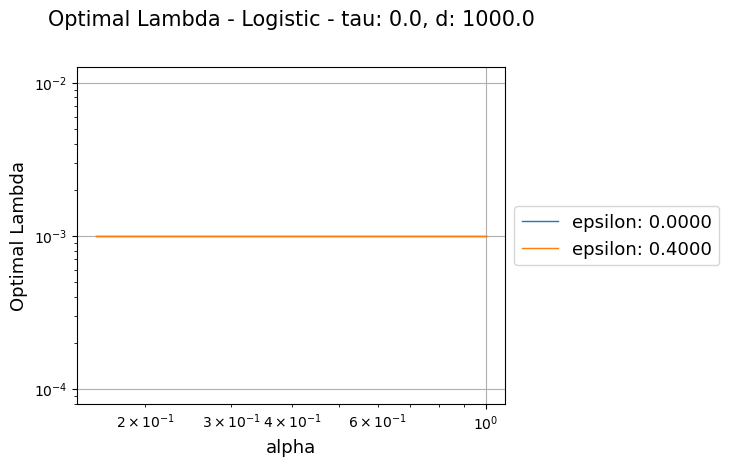

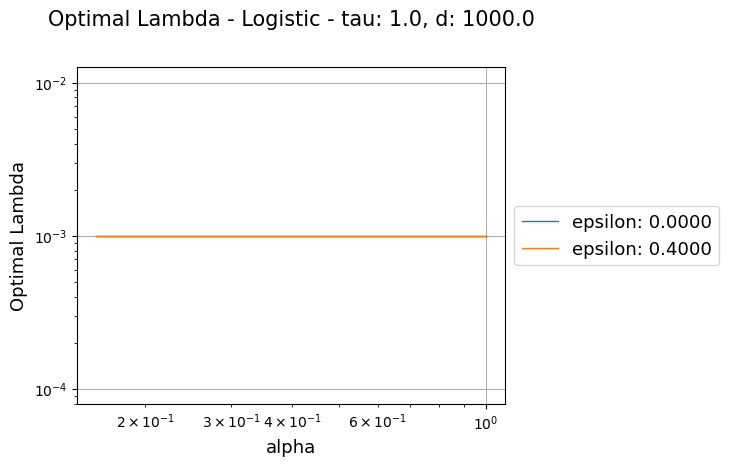

In [88]:
create_plot(df,"Optimal Lambda", "lam", None,filename="Optimal_lambda")

/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50464/2716175861.py:98: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log')


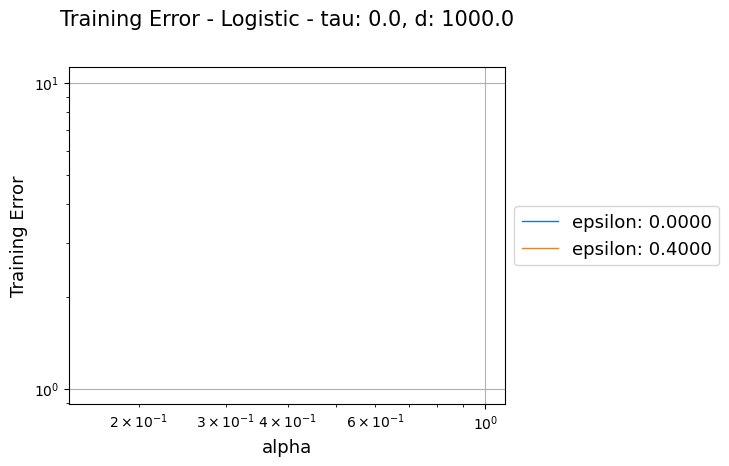

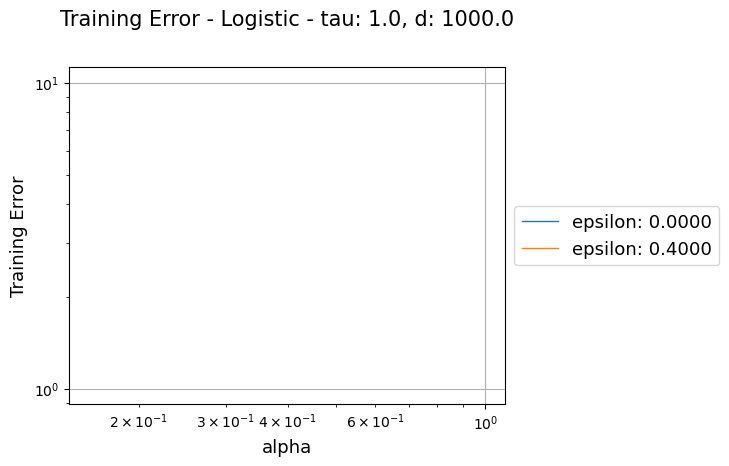

In [89]:
# plot the erm training error
create_plot(df, "Training Error", "training_error_state_evolution","training_error_erm")

In [90]:
# # Let's add a new column to the dataframe for the training error in terms of erm overlaps, except for sigma

# df.apply()

# training_error_overlaps: float = training_error_logistic(m,Q,sigma,A,N,rho,n/d,tau,epsilon, lam)

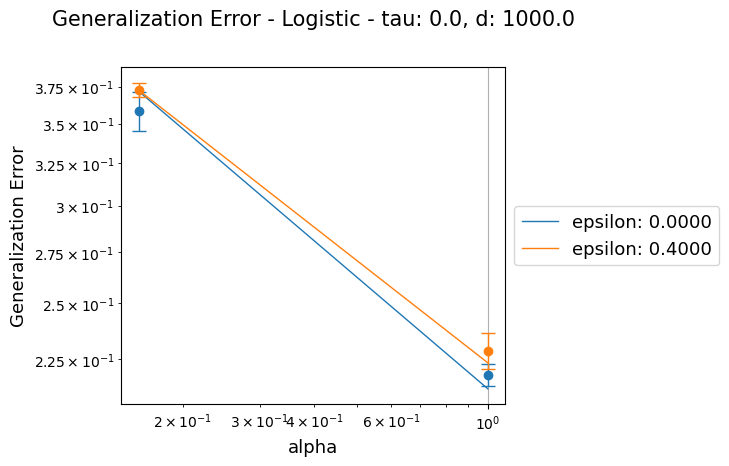

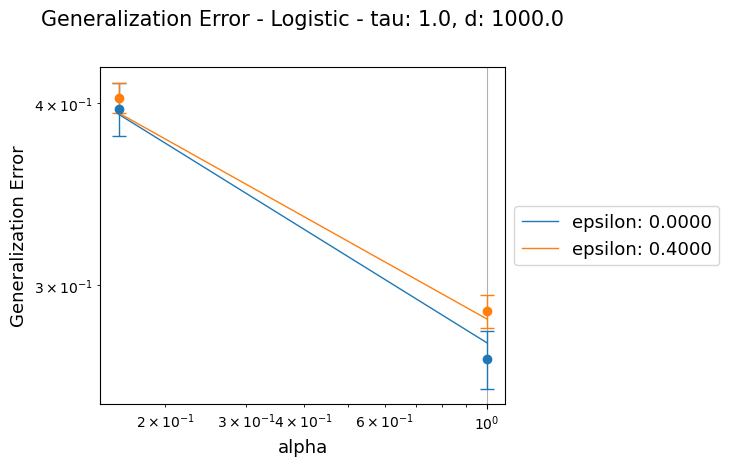

In [91]:
create_plot(df, "Generalization Error", "generalization_error_state_evolution", "generalization_error_erm_erm", log_y=True)

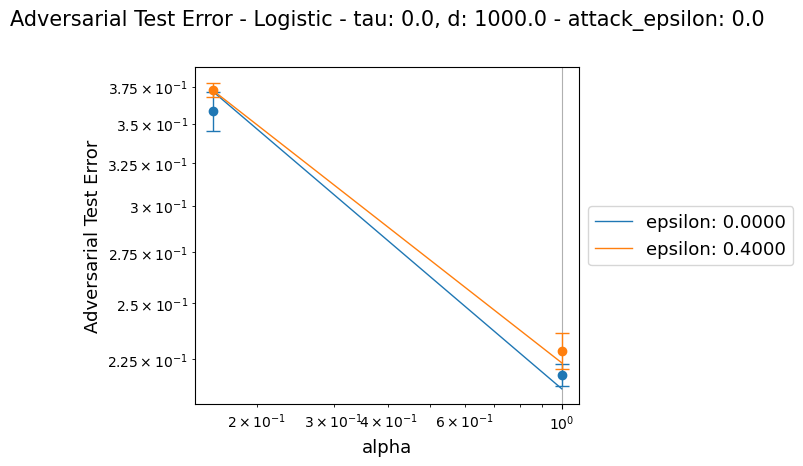

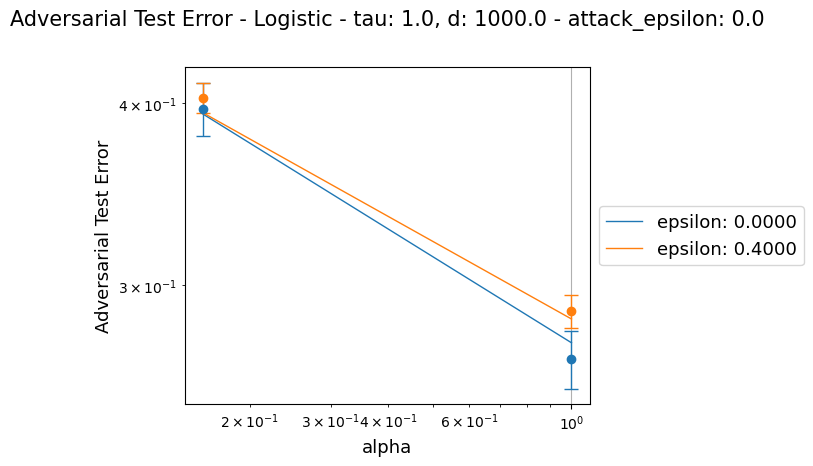

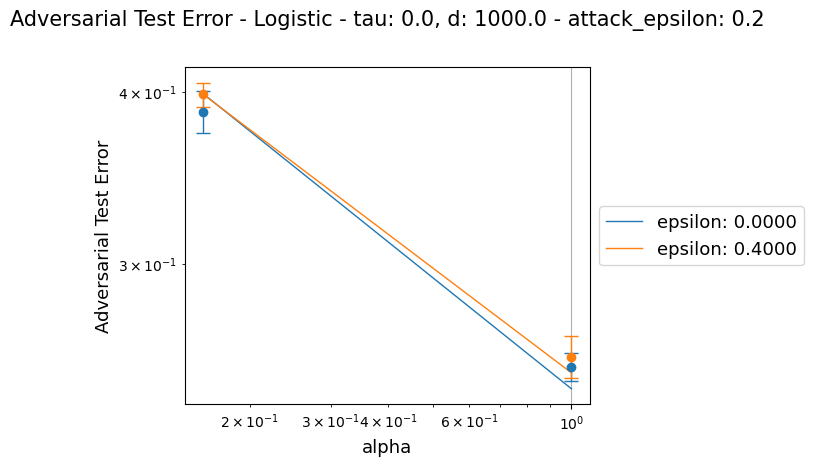

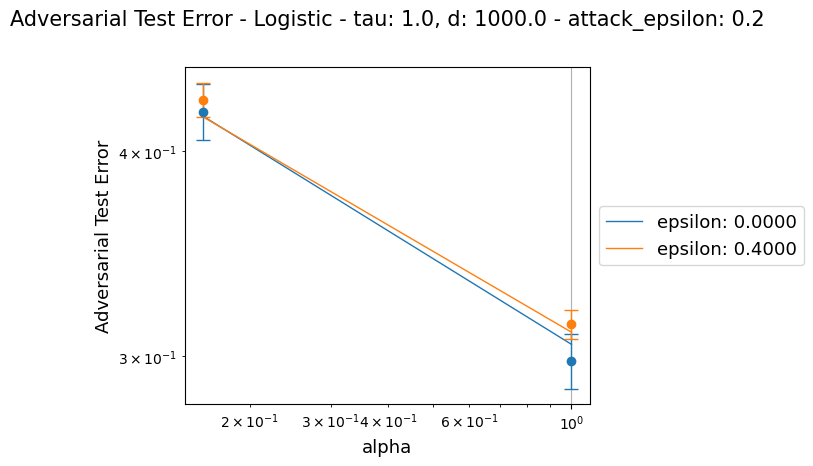

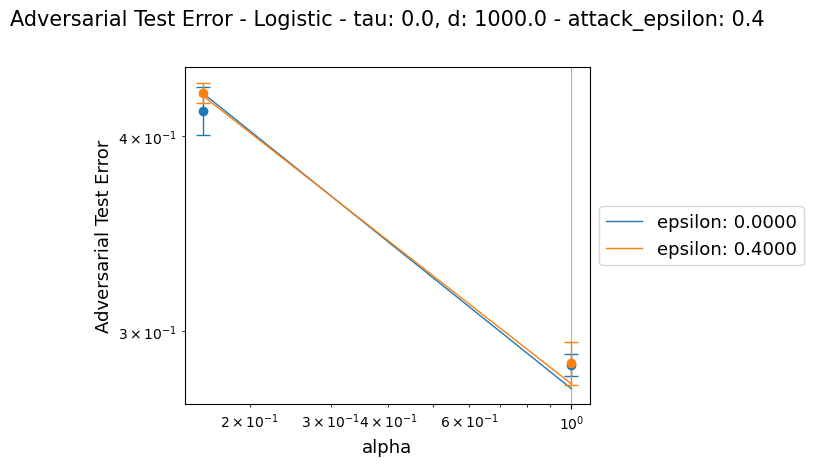

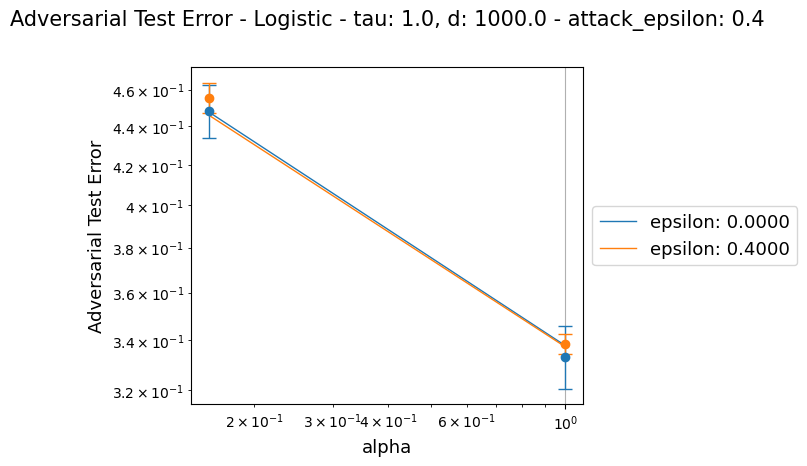

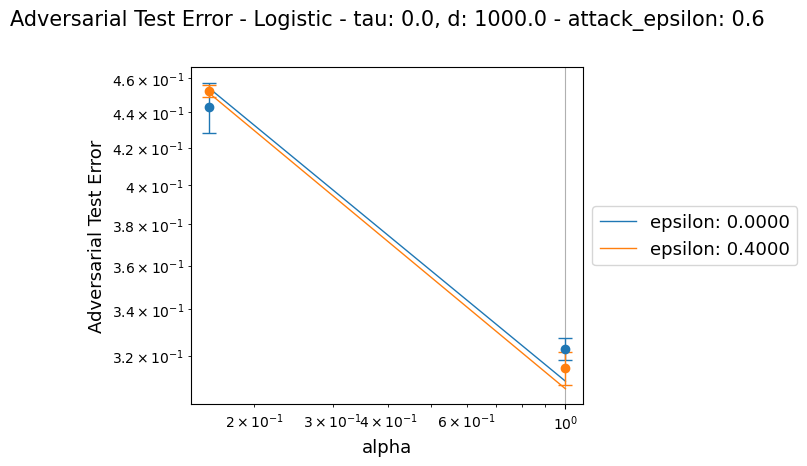

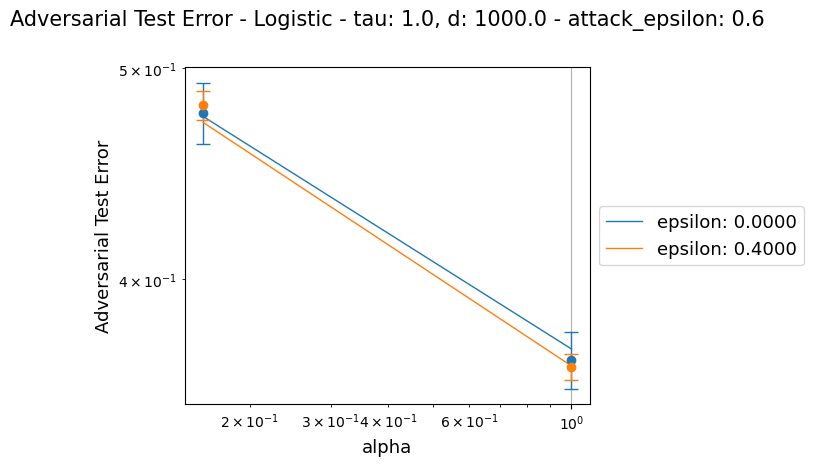

In [92]:
create_plot(df, "Adversarial Test Error", "adversarial_generalization_error_state_evolution", "adversarial_generalization_error_erm",log_y=True,log_x=True,plot_attack_epsilon=True)

/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50464/2716175861.py:98: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log')


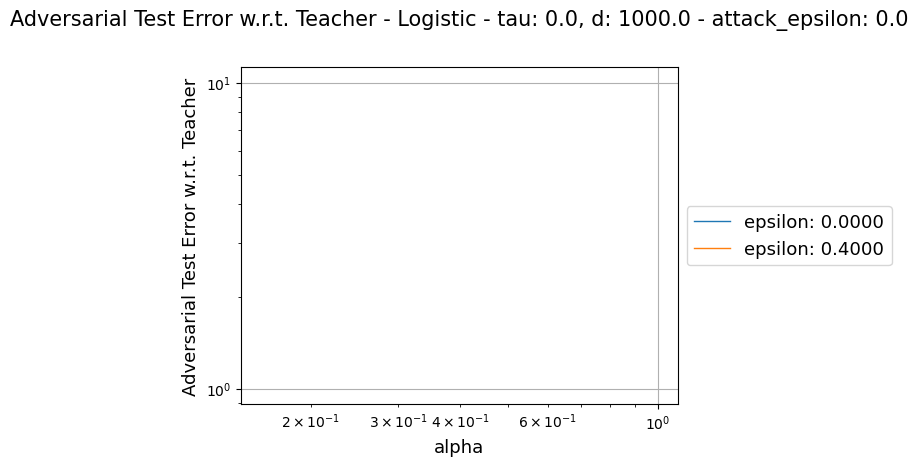

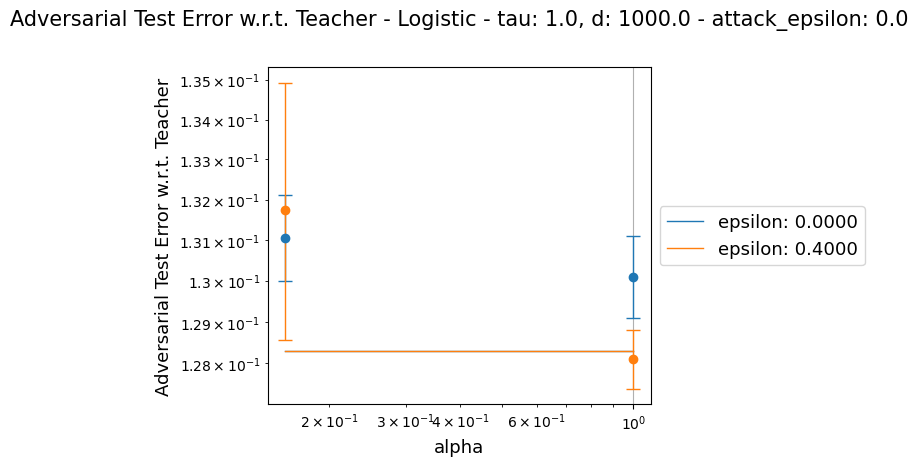

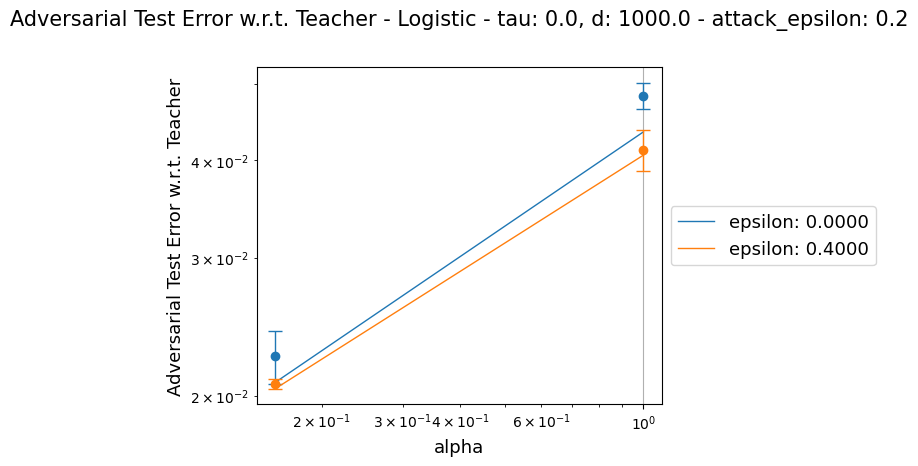

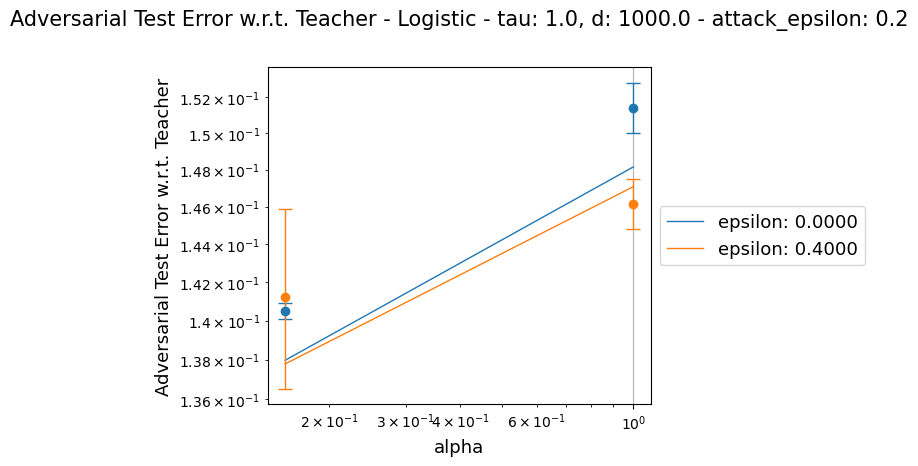

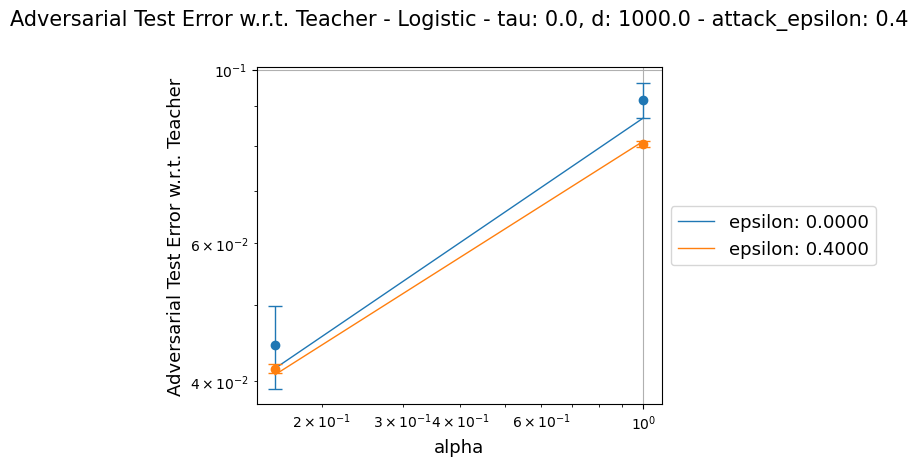

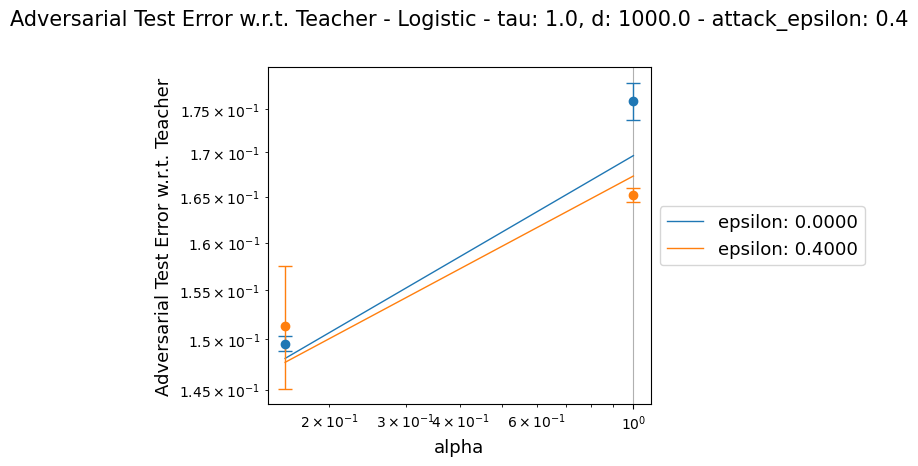

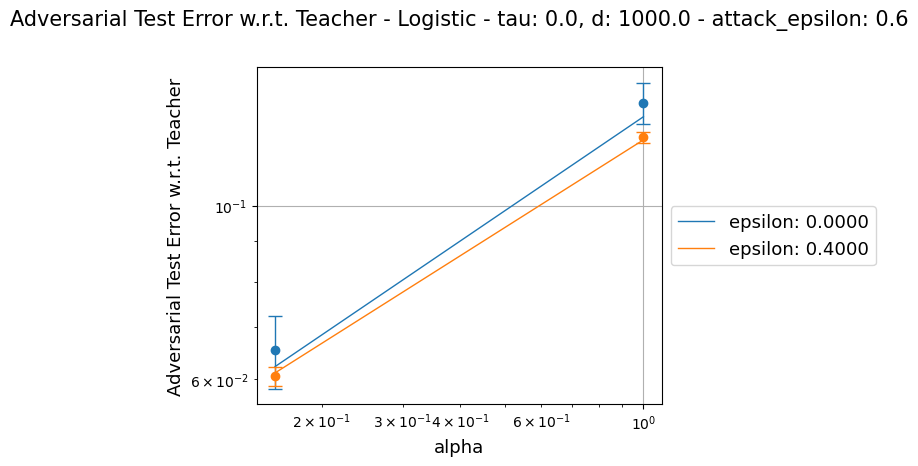

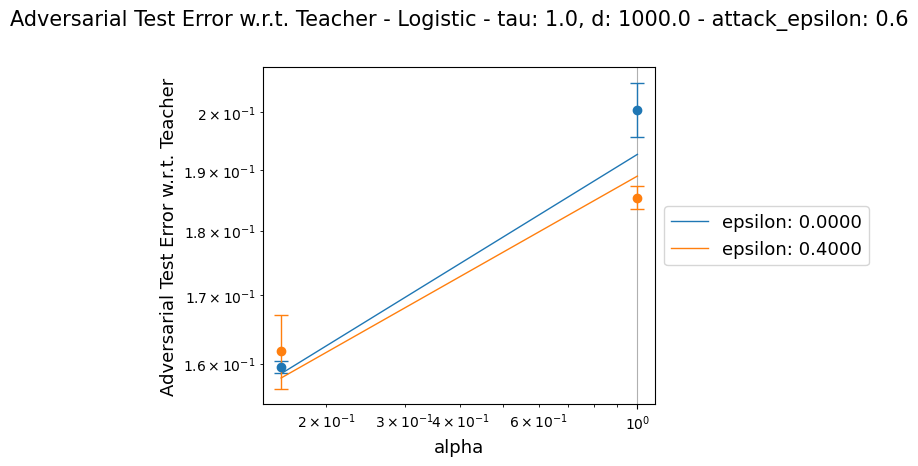

In [93]:
create_plot(df, "Adversarial Test Error w.r.t. Teacher", "adversarial_generalization_error_teacher_state_evolution", "adversarial_generalization_error_teacher_erm",log_y=True,log_x=True,plot_attack_epsilon=True)

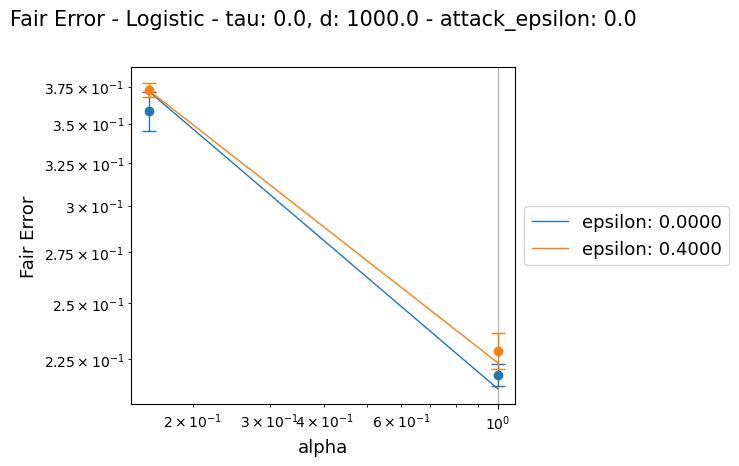

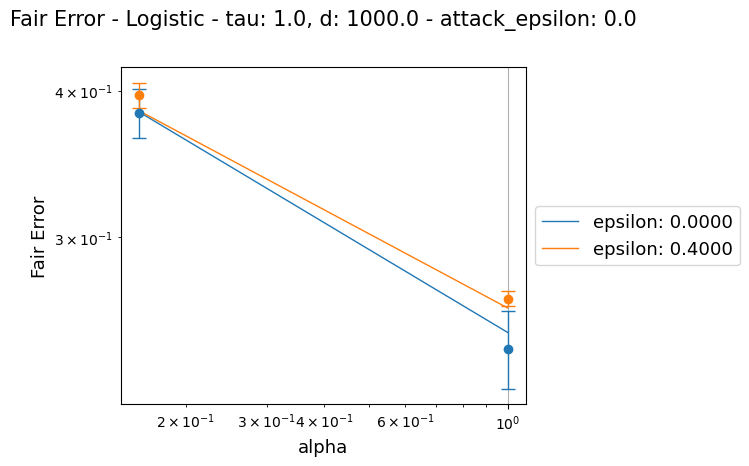

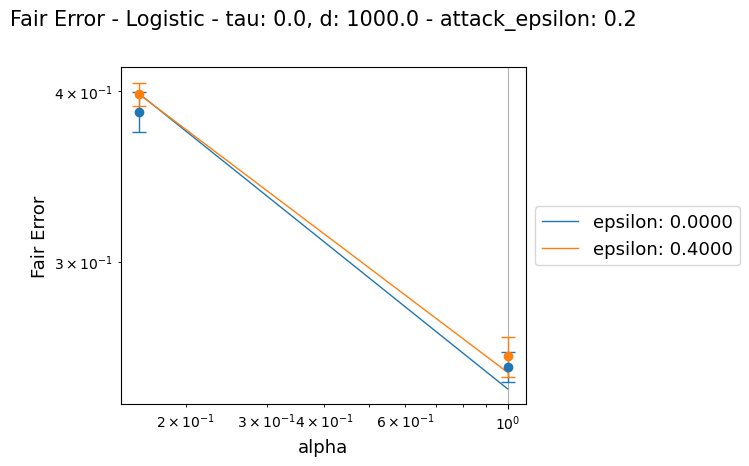

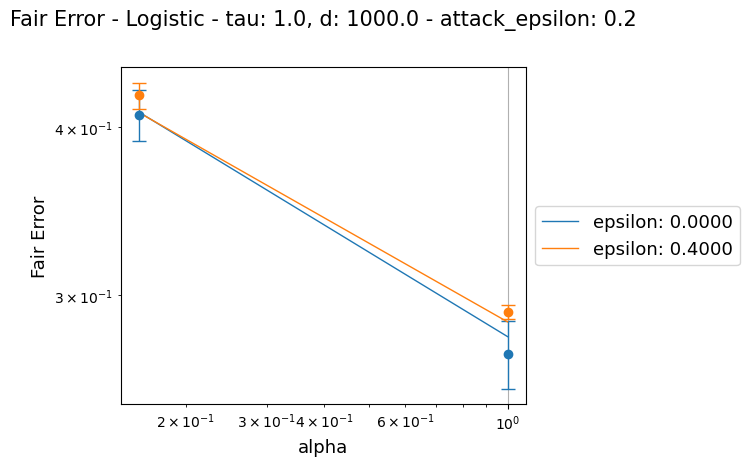

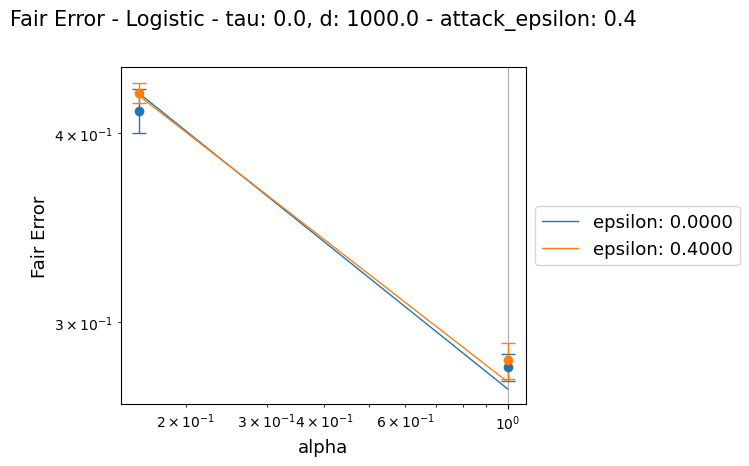

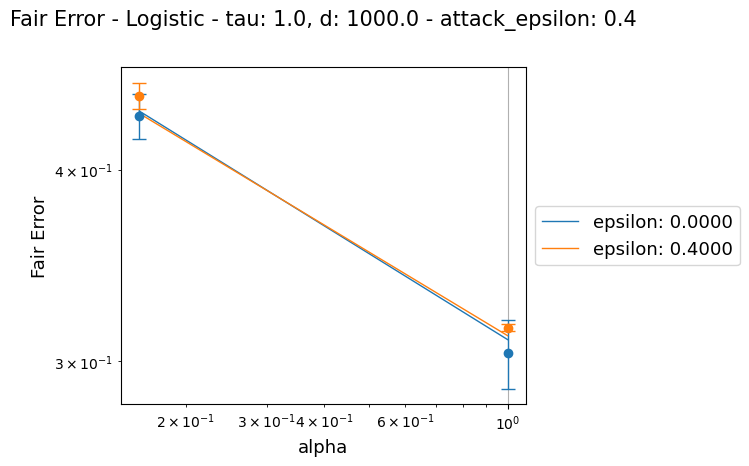

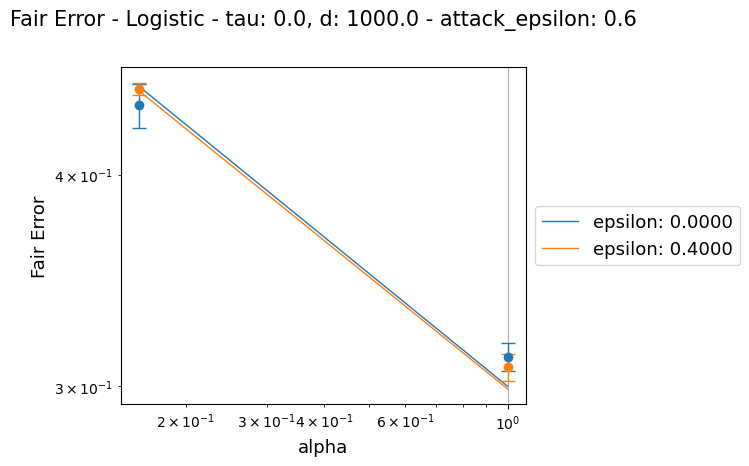

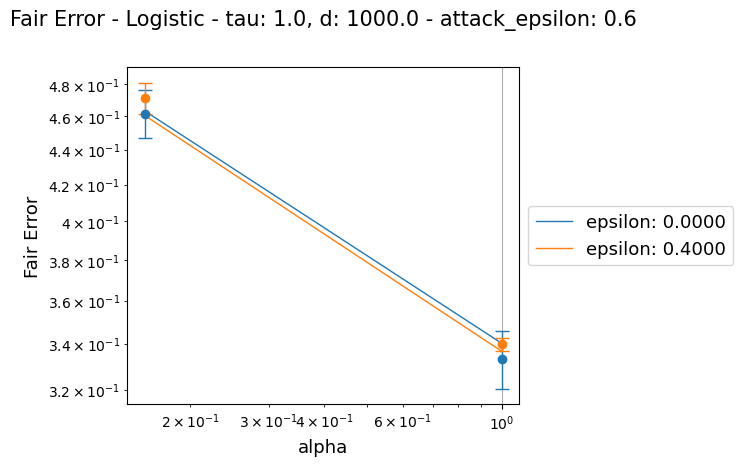

In [94]:
# plot the fair adversarial error
create_plot(df, "Fair Error", "fair_adversarial_error_state_evolution","fair_adversarial_error_erm",plot_attack_epsilon=True)

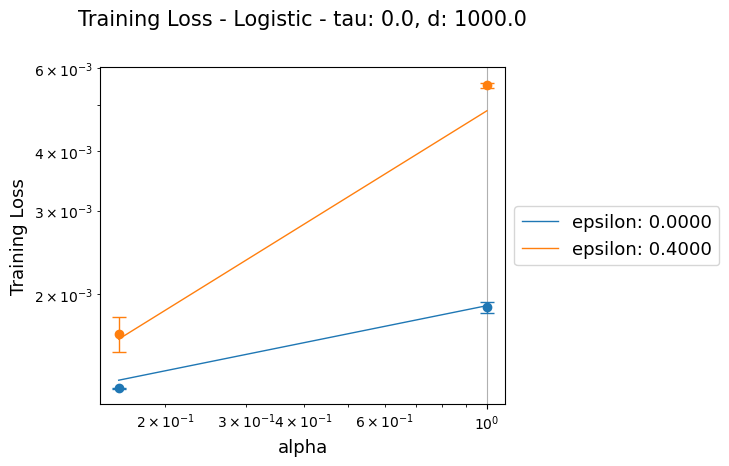

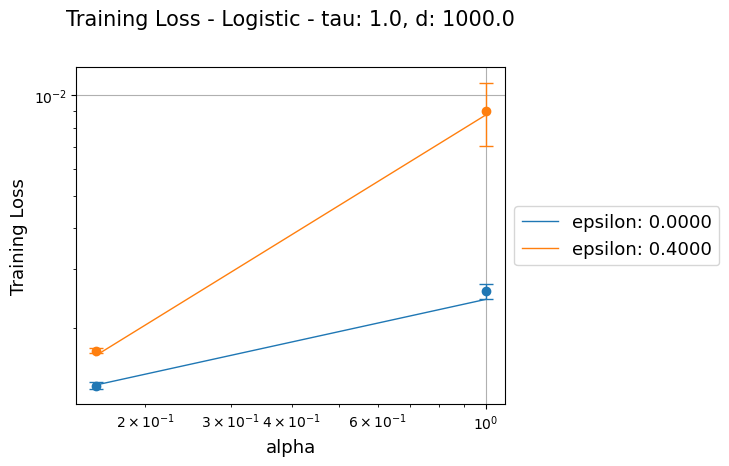

In [95]:
create_plot(df, "Training Loss", "training_loss_state_evolution", "training_loss_erm", log_y=True)

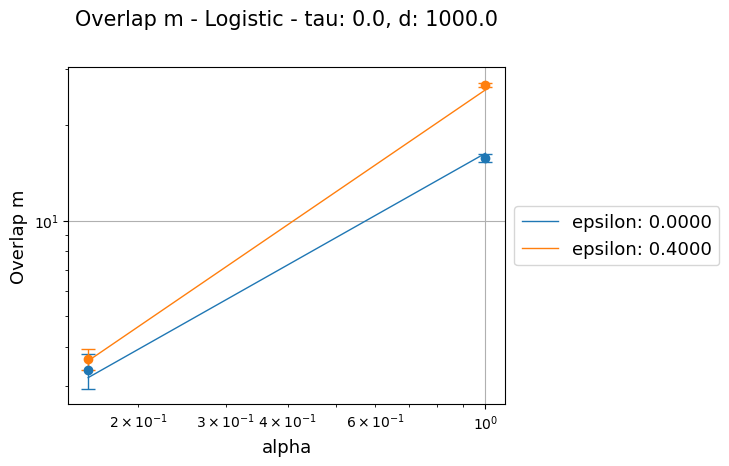

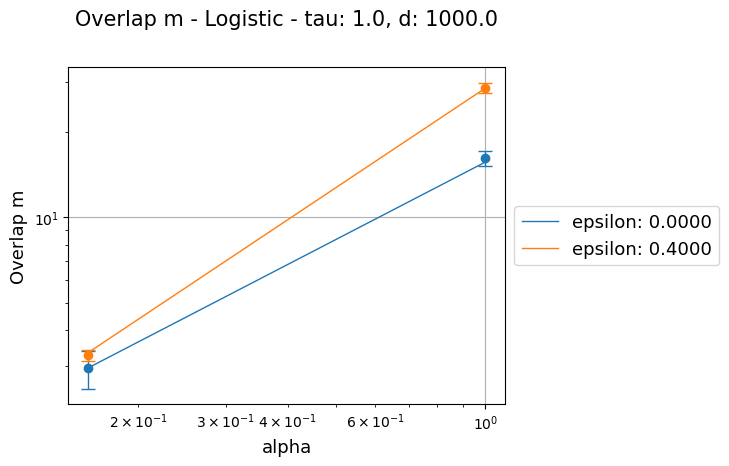

In [96]:
create_plot(df, "Overlap m", "m_state_evolution","m_erm")

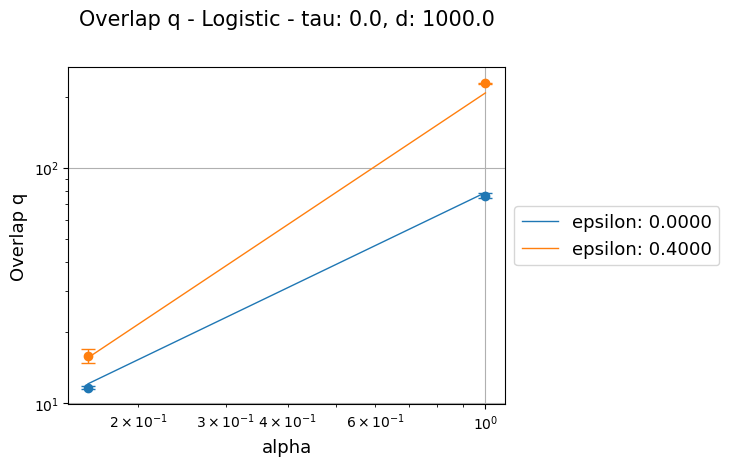

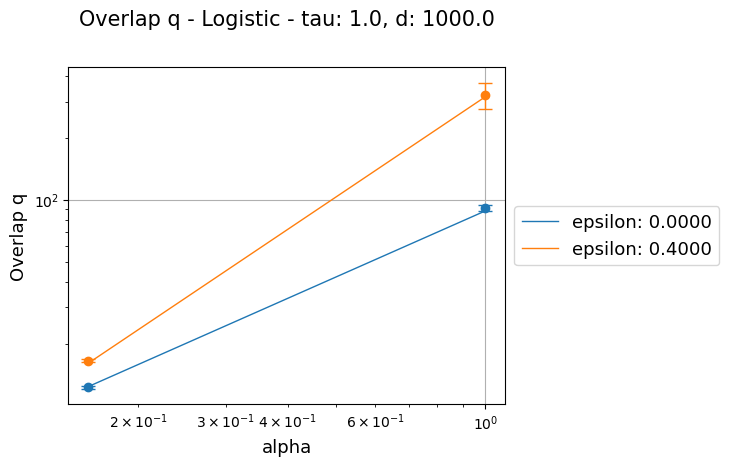

In [97]:
create_plot(df, "Overlap q", "q_state_evolution","q_erm", log_y=True)

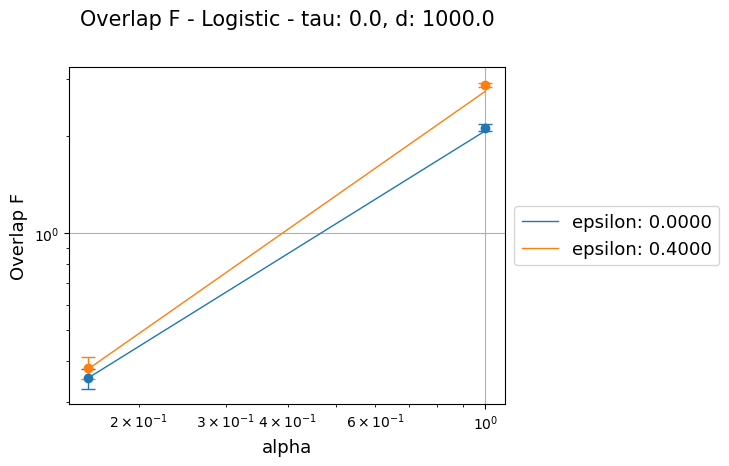

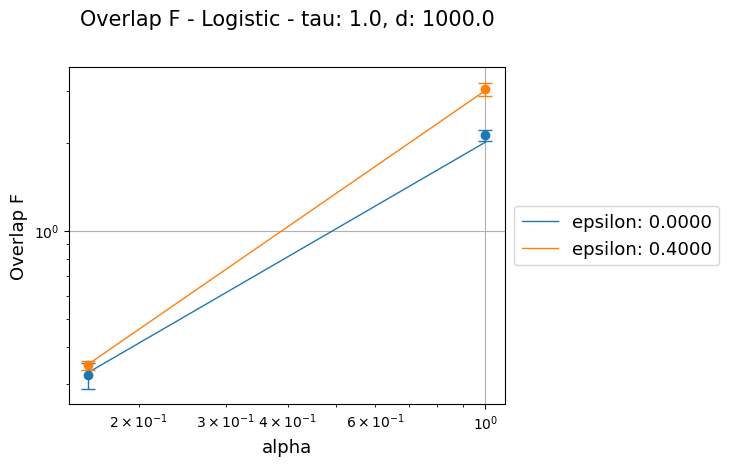

In [98]:
# Plot the F overlap
create_plot(df, "Overlap F", "F_state_evolution","F_erm", log_y=True)

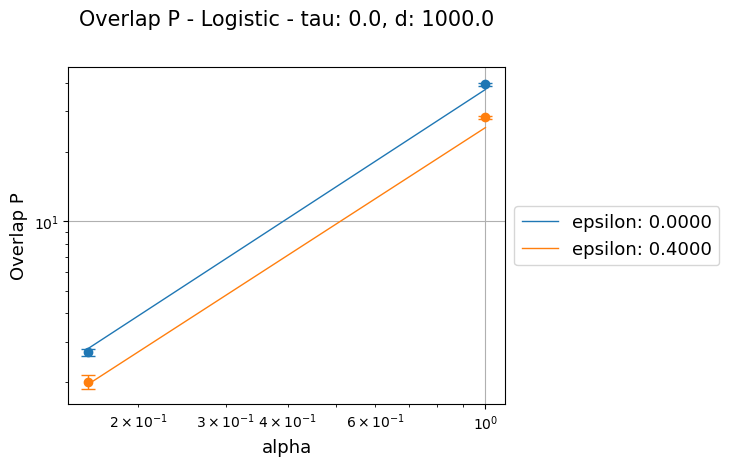

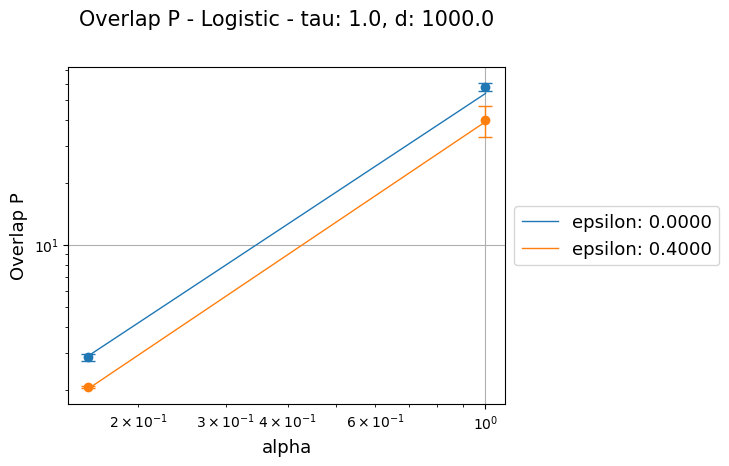

In [99]:
# Plot the P overlap
create_plot(df, "Overlap P", "P_state_evolution","P_erm", log_y=True)

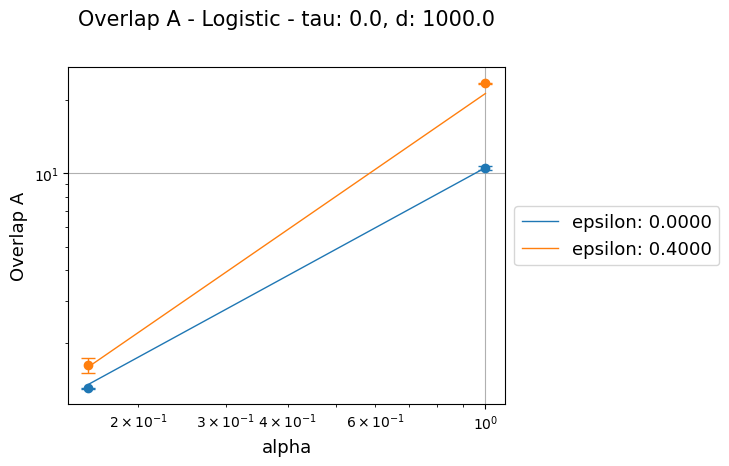

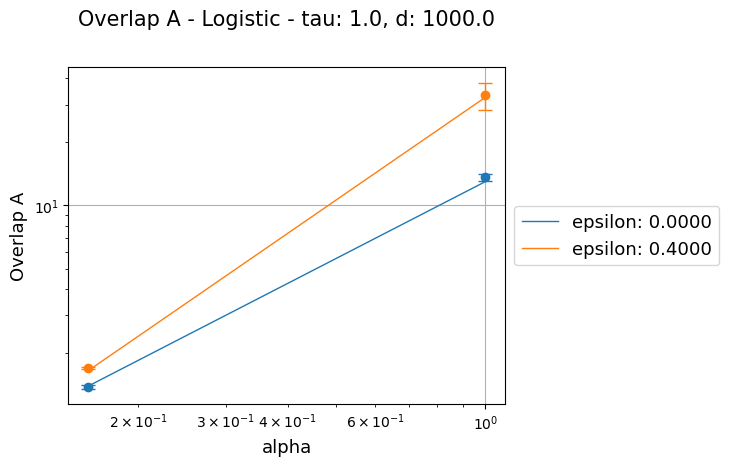

In [100]:
# Plot the A overlap
create_plot(df, "Overlap A", "A_state_evolution","A_erm", log_y=True)

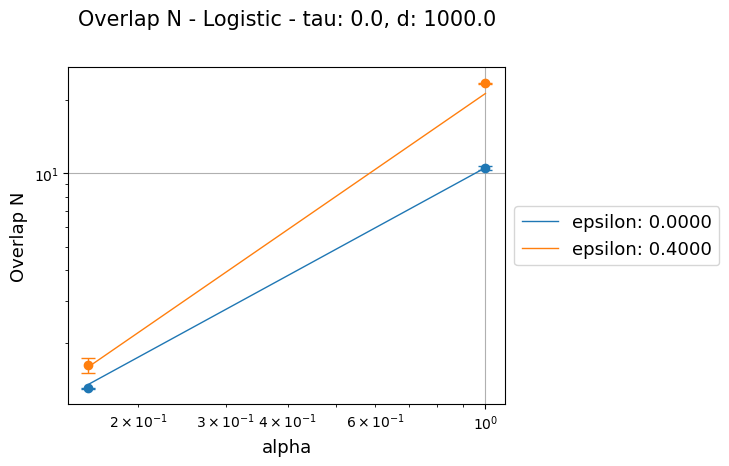

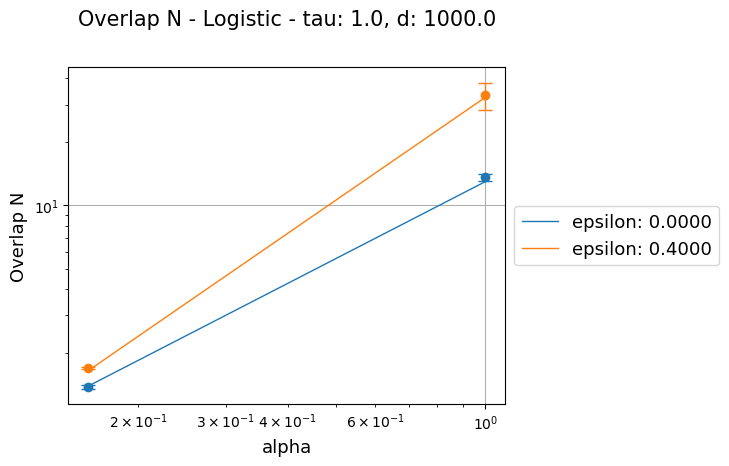

In [101]:
# Plot the N overlap
create_plot(df, "Overlap N", "N_state_evolution","N_erm", log_y=True)

In [102]:
# # subset df to keep only where p = 0.5
# p = 0.6
# dfp = df[df.index.get_level_values("p_calibration") == p]
# # remove epsilon = 1
# # dfp = dfp[dfp.index.get_level_values("epsilon") != 1]

# create_plot(dfp, f"Calibration p: {p}", "calibration_state_evolution","erm_calibration_erm",log_y=False)
# # erm_calibration_erm	analytical_calibration_erm	calibration_state_evolution

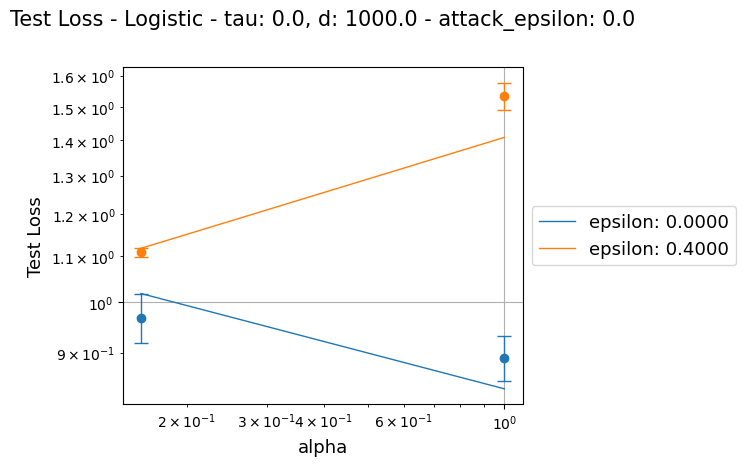

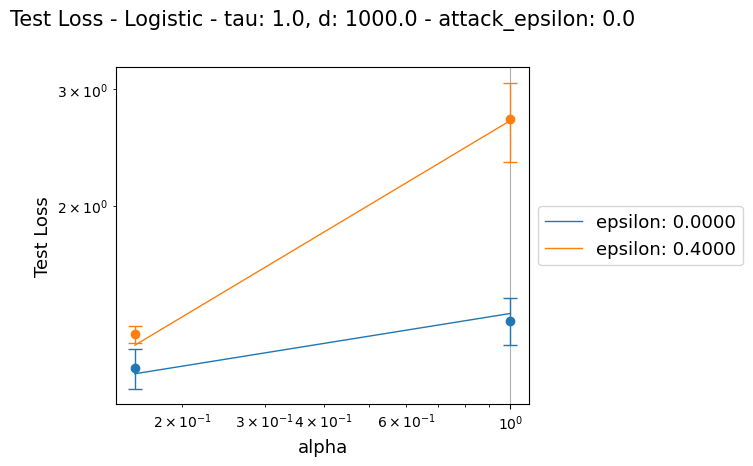

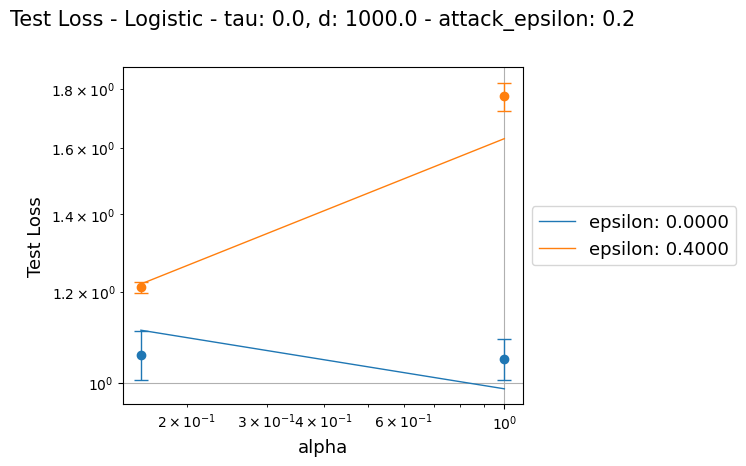

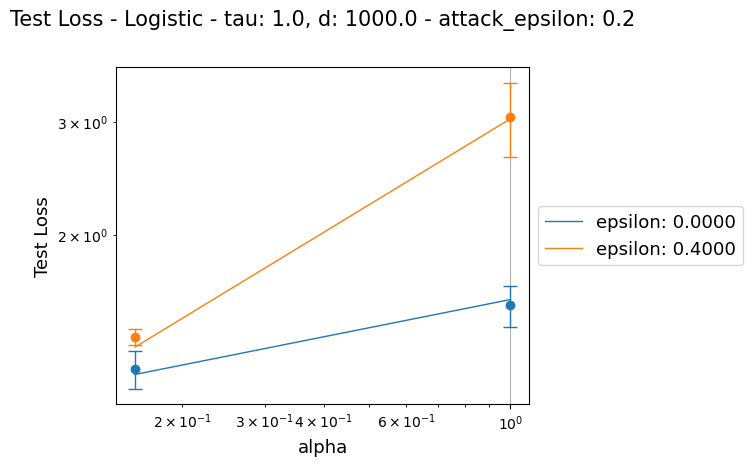

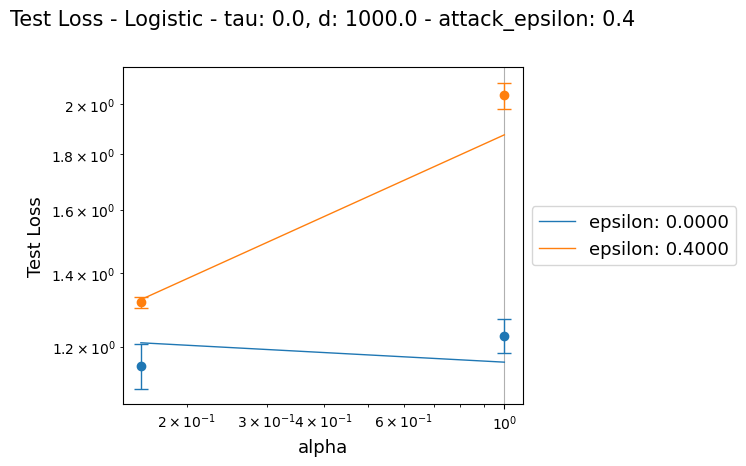

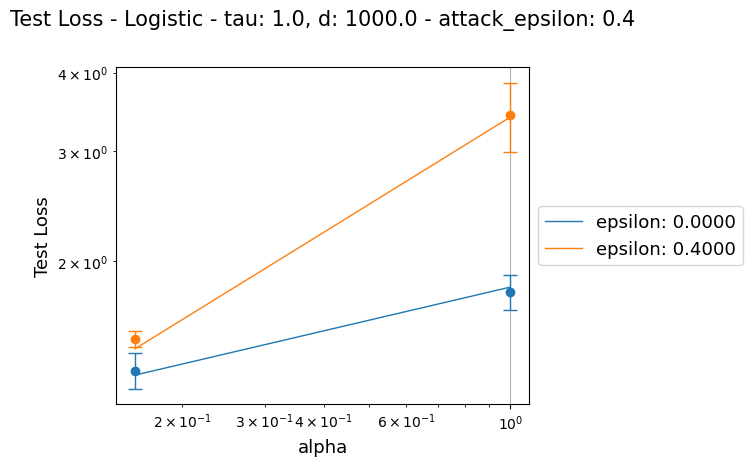

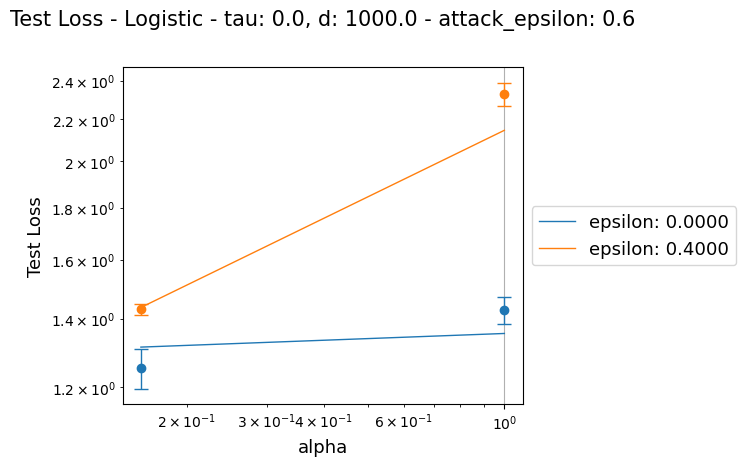

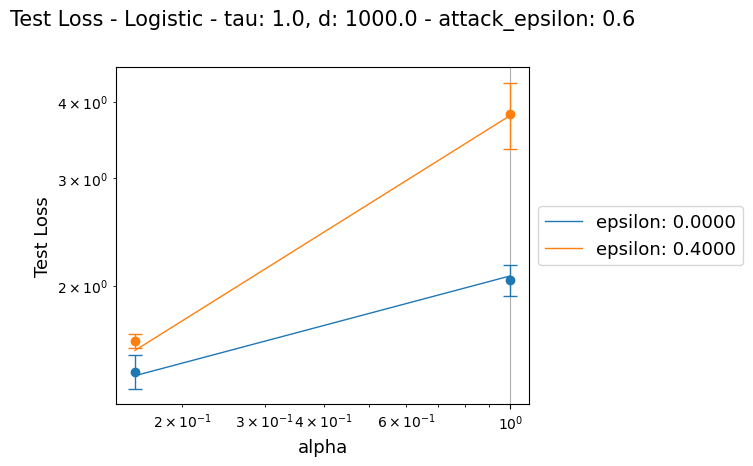

In [103]:
# plot test loss erm
create_plot(df, "Test Loss", "test_loss_state_evolution","test_loss_erm",log_y=True,plot_attack_epsilon=True)

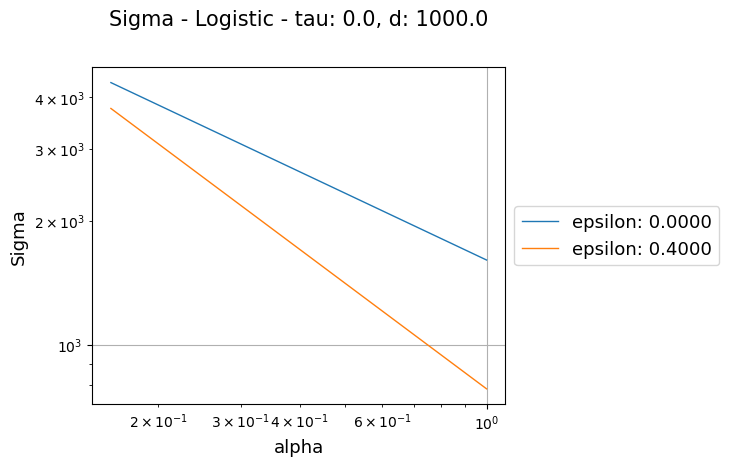

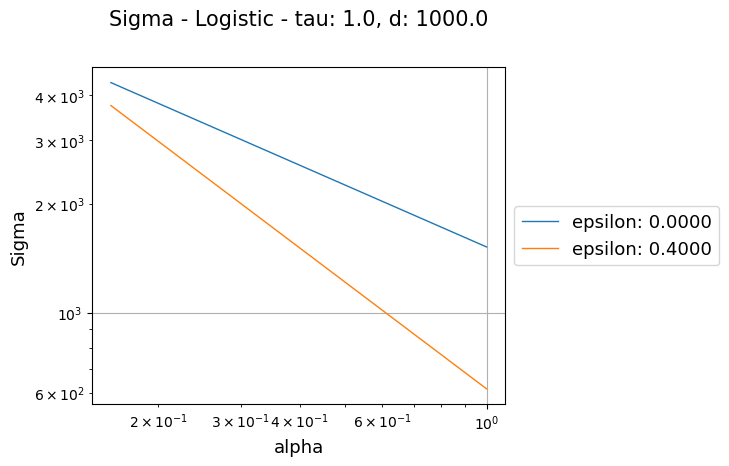

In [104]:
# Plot sigma for the state evolution
create_plot(df, "Sigma", "sigma_state_evolution", None)

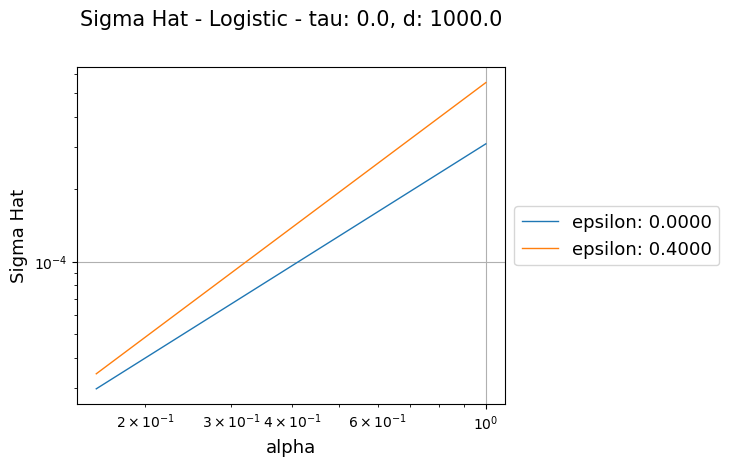

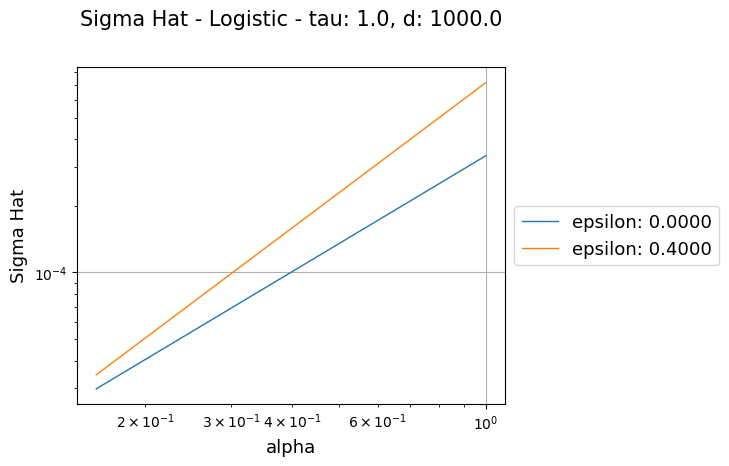

In [105]:
# Plot sigma_hat for the state evolution
create_plot(df, "Sigma Hat", "sigma_hat_state_evolution", None)

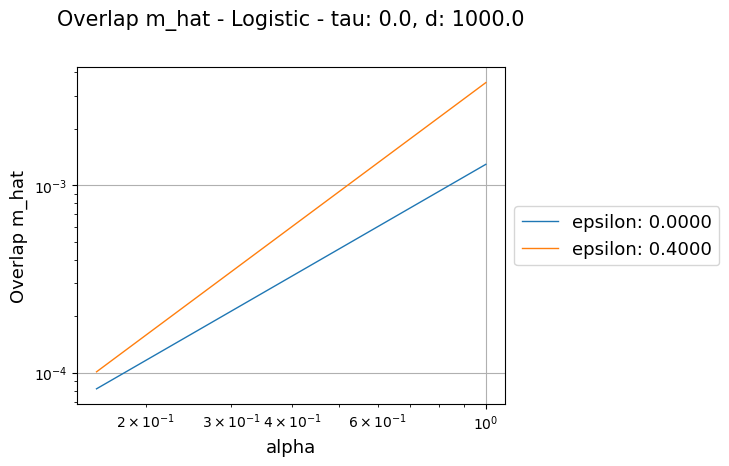

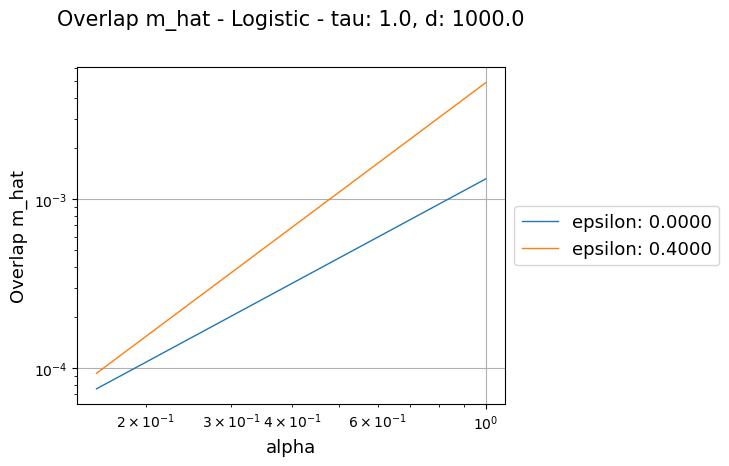

In [106]:
# Plot m_hat for the state evolution
create_plot(df, "Overlap m_hat", "m_hat_state_evolution", None)

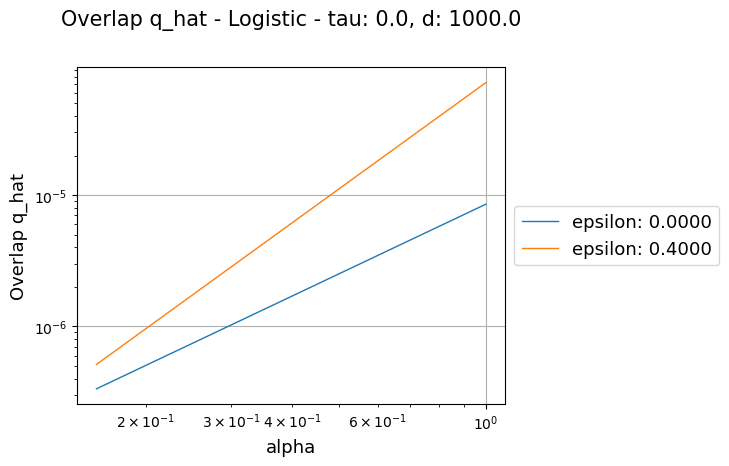

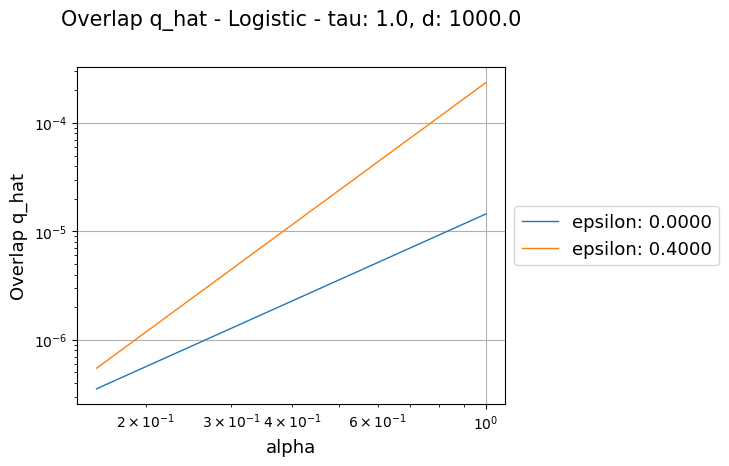

In [107]:
# Plot q_hat for the state_evolution
create_plot(df, "Overlap q_hat", "q_hat_state_evolution", None)

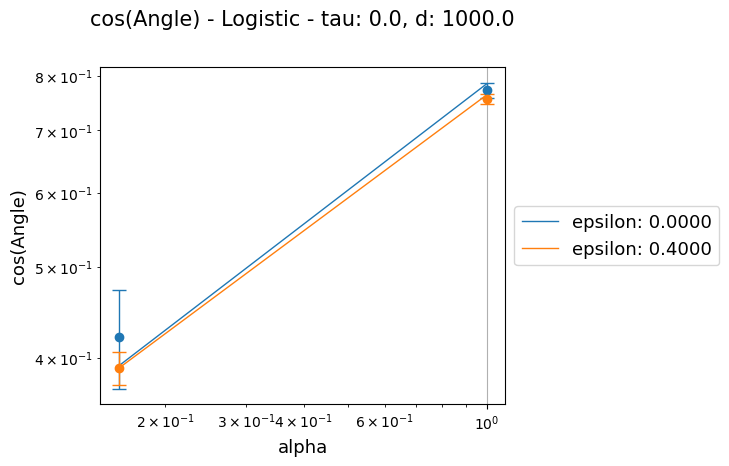

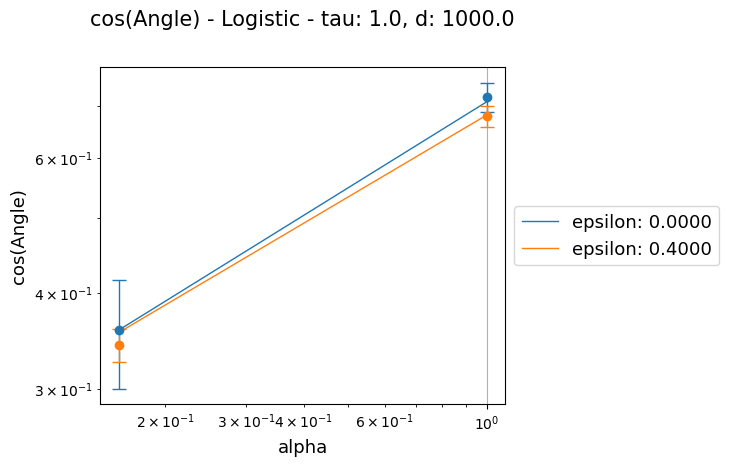

In [108]:
create_plot(df, "cos(Angle)", "angle_state_evolution","angle_erm")

# Plot the subspace overlaps

In [109]:
experiment = ExperimentInformation.from_df(df_experiments.iloc[experiment_loc])
experiment.data_model_type

<DataModelType.KFeaturesModel: 5>

In [110]:
# load the data_model and store it in a dictionary
data_model = experiment.get_data_model(logger,source_pickle_path="", name = experiment.data_model_name)

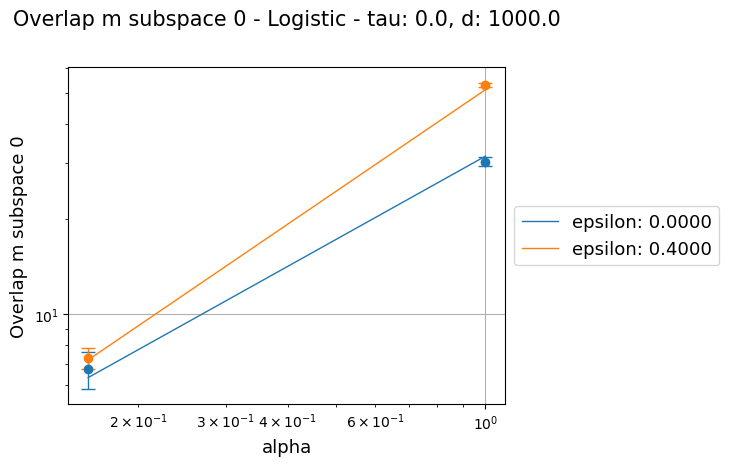

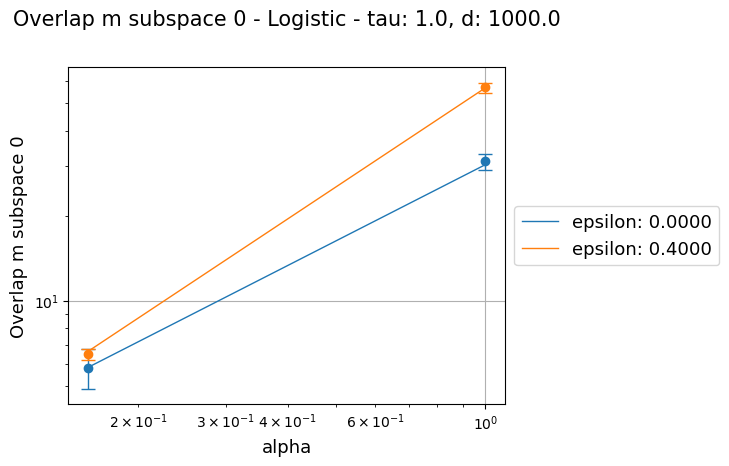

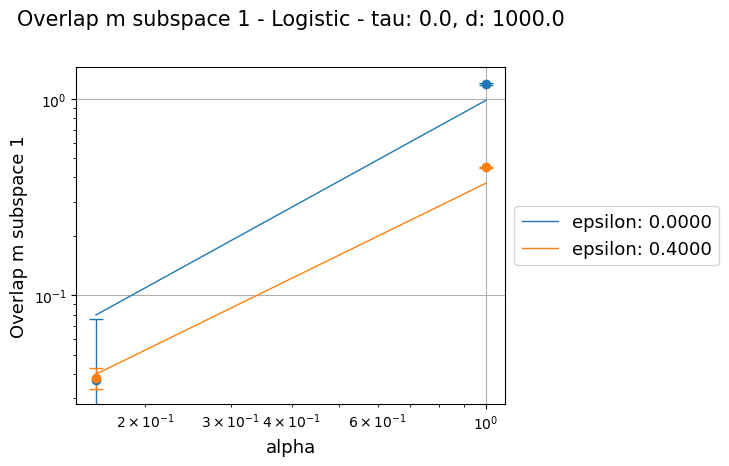

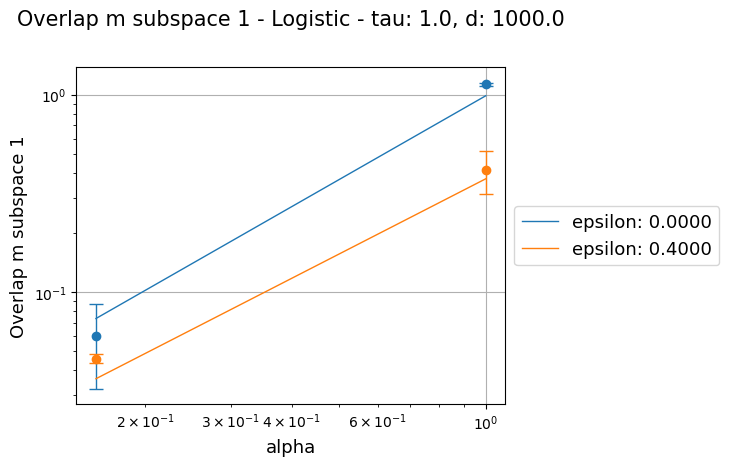

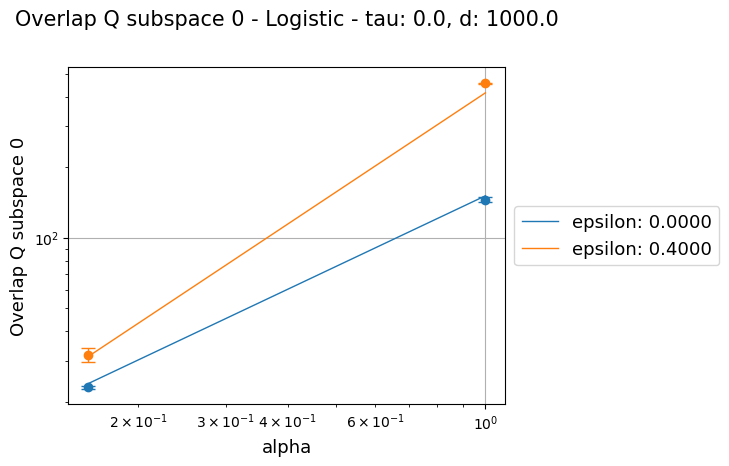

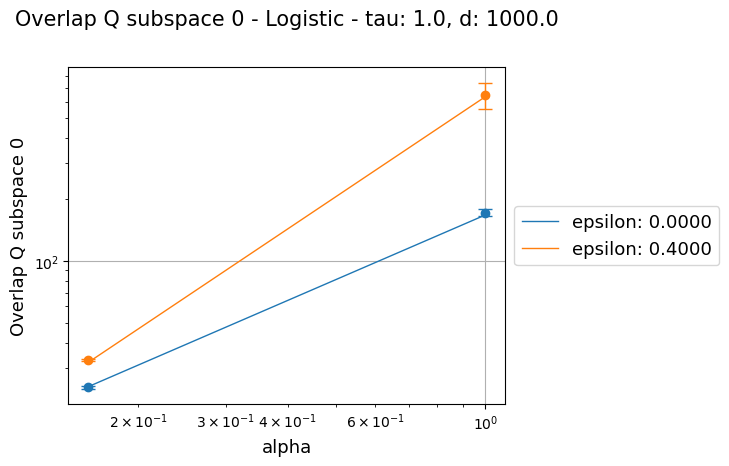

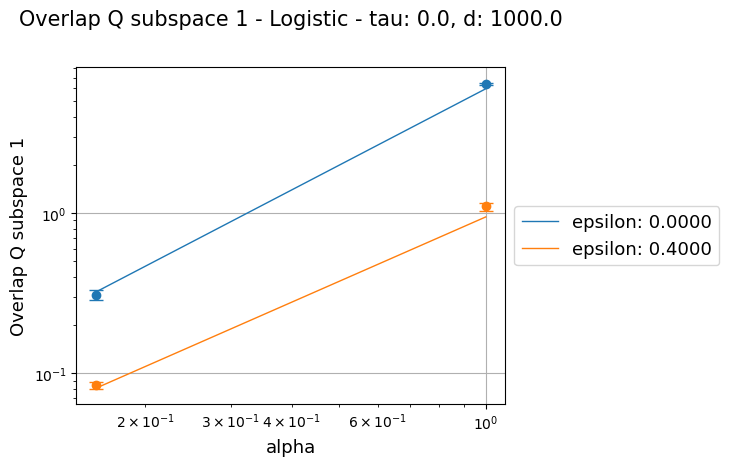

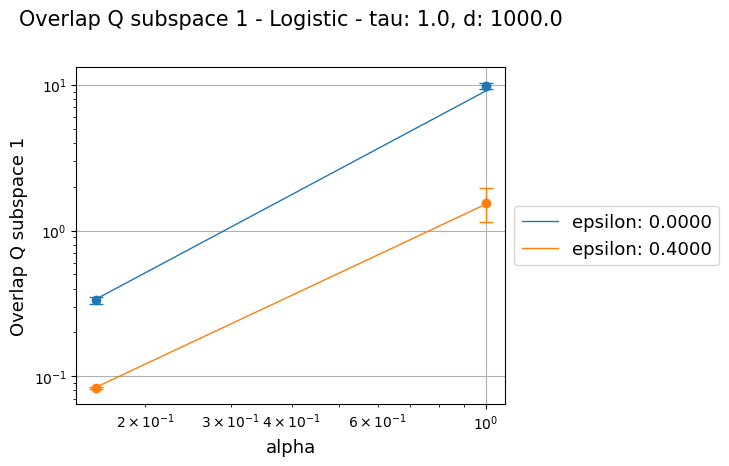

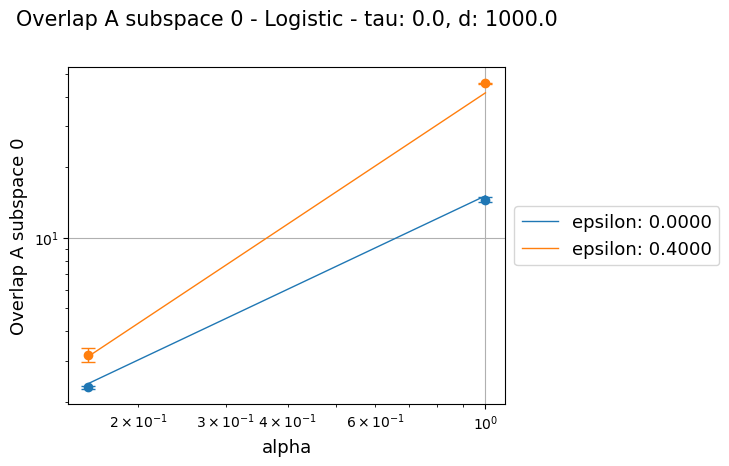

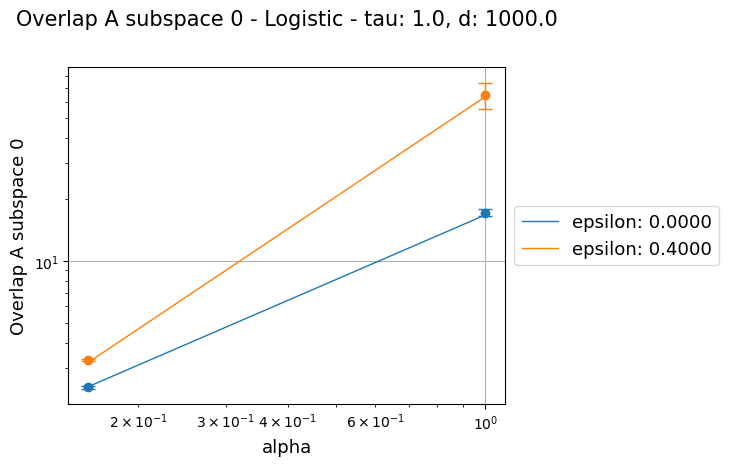

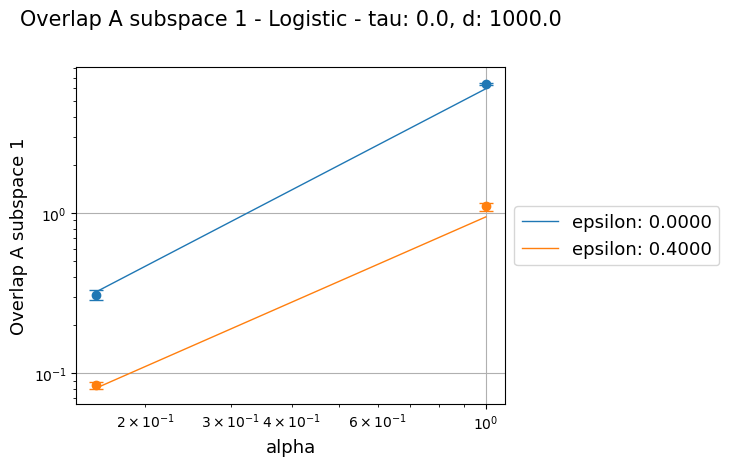

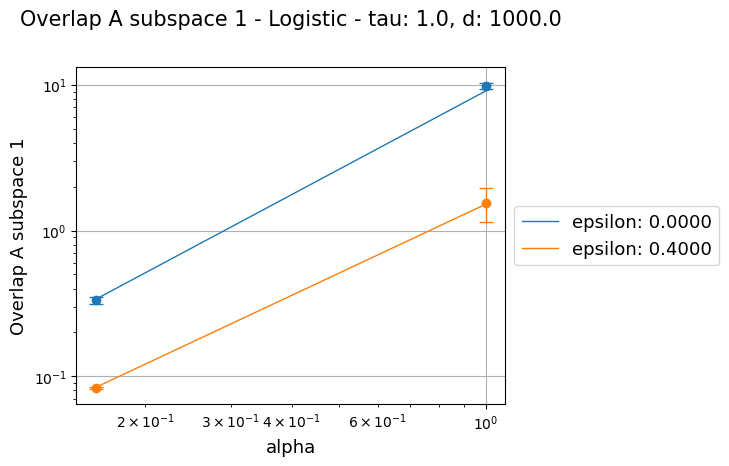

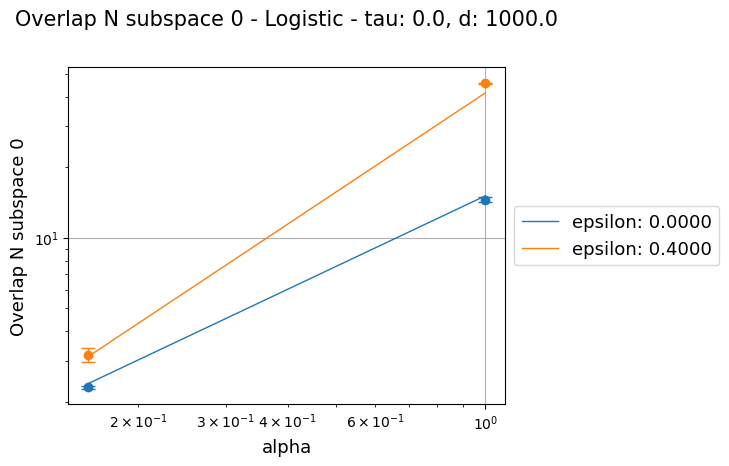

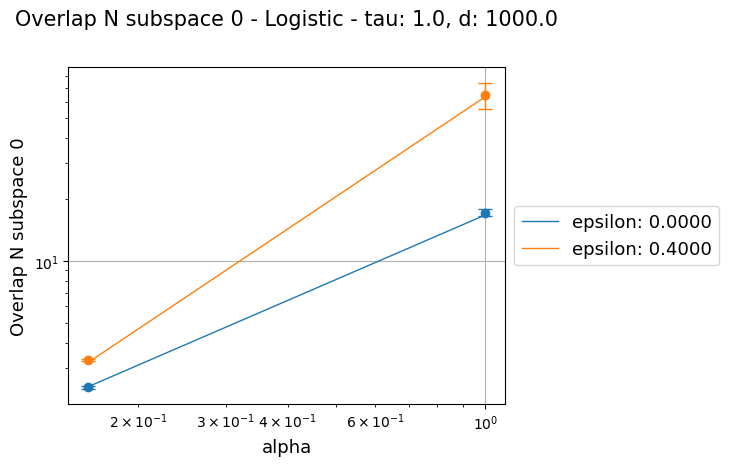

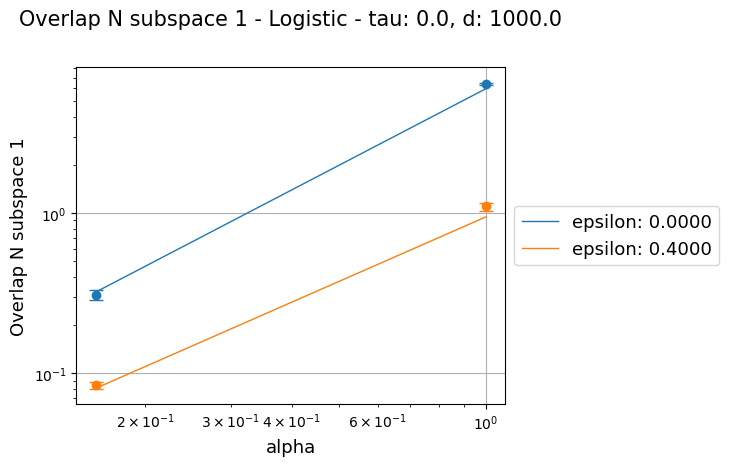

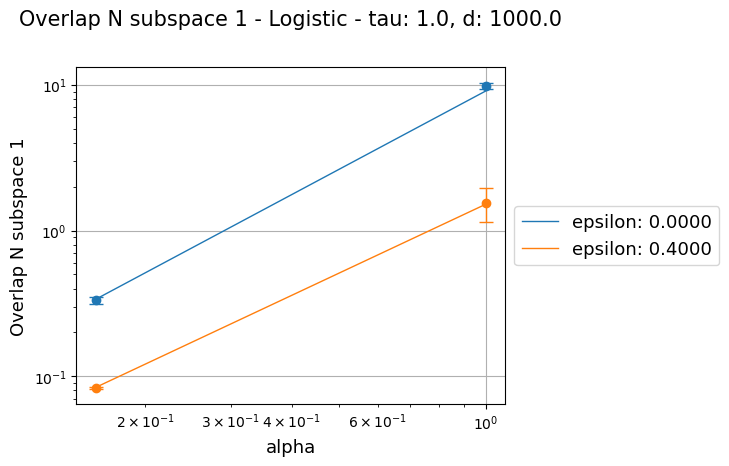

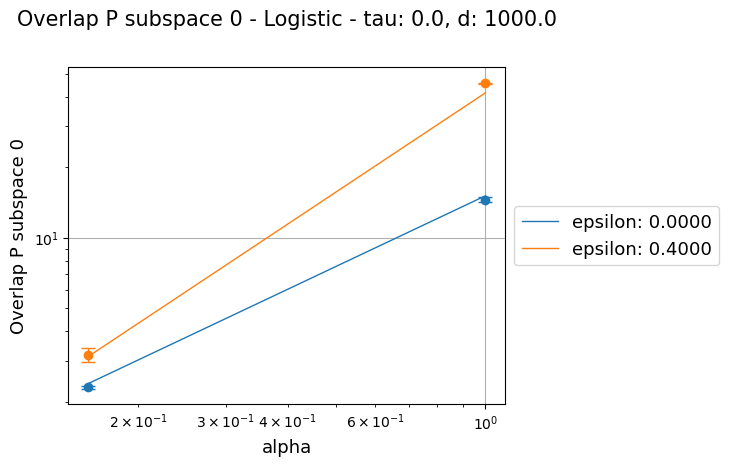

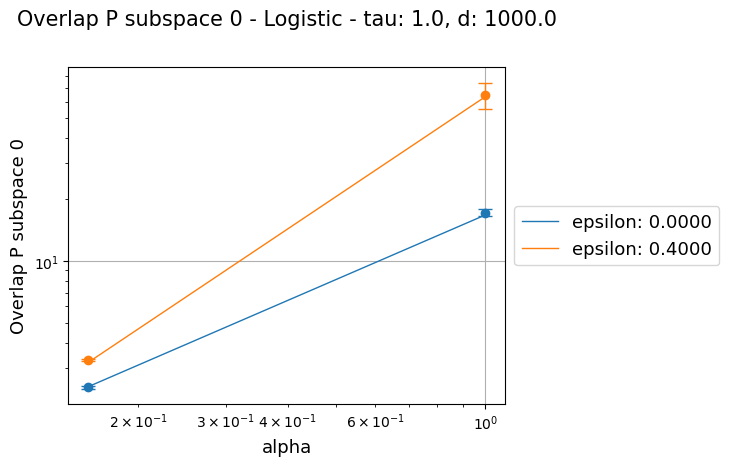

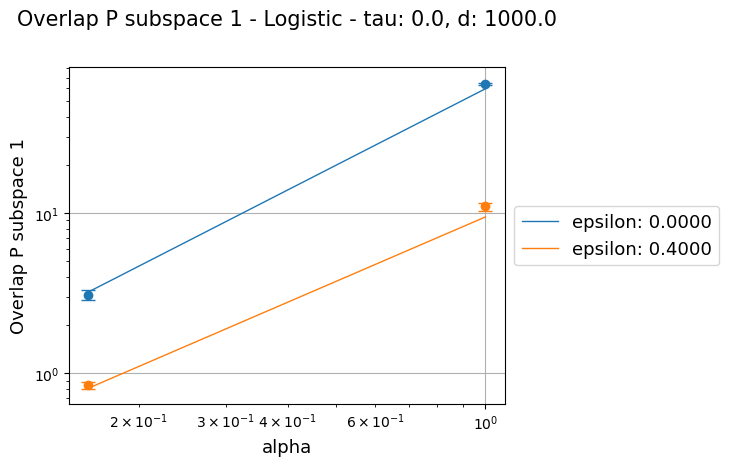

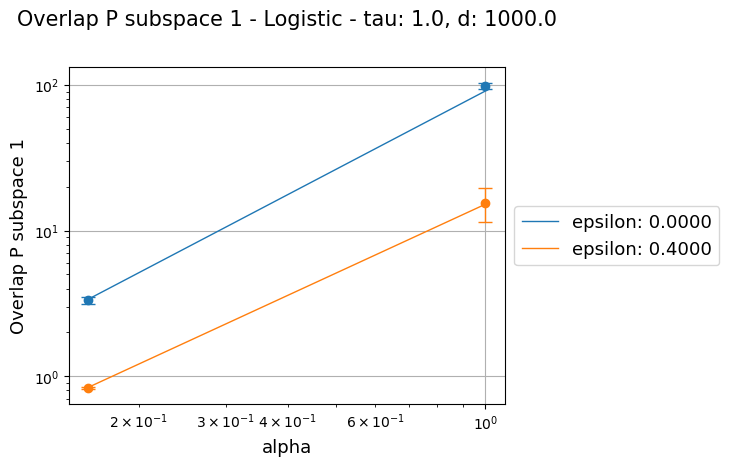

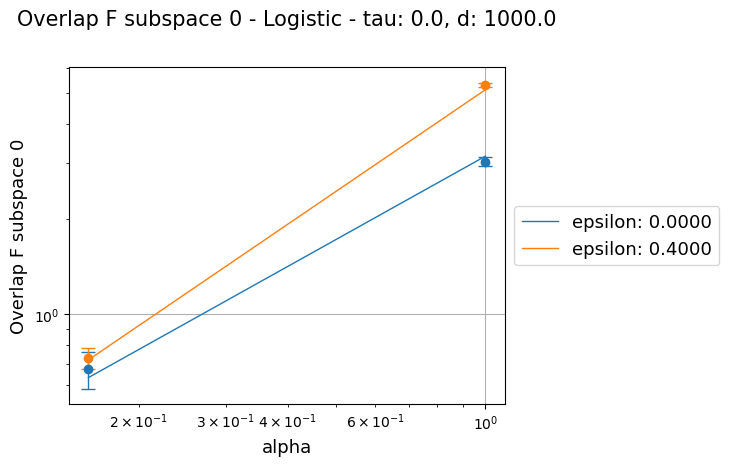

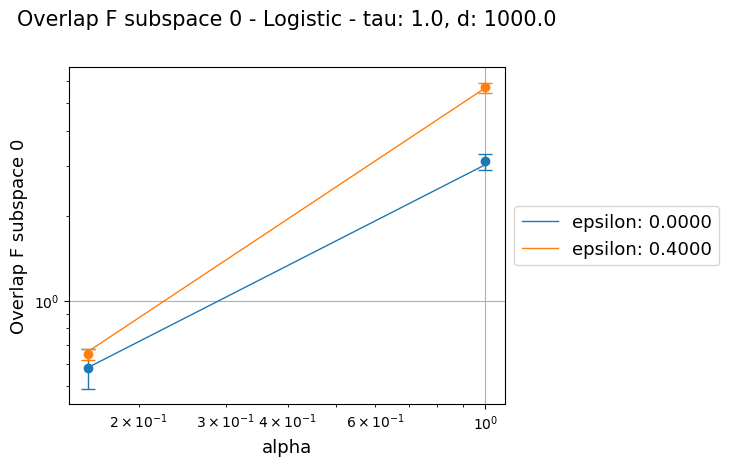

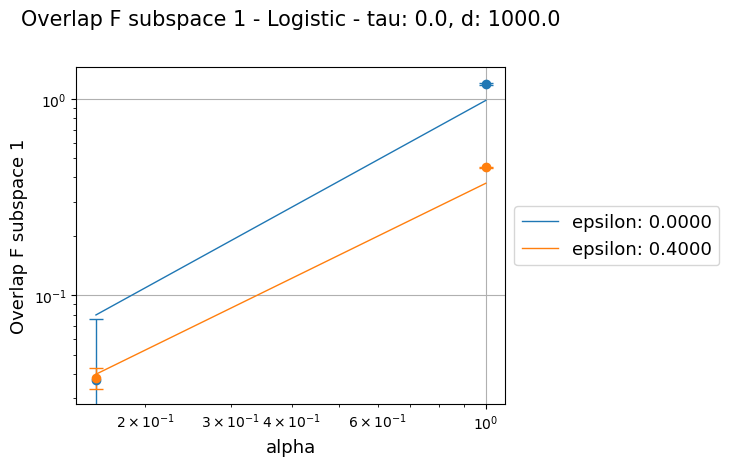

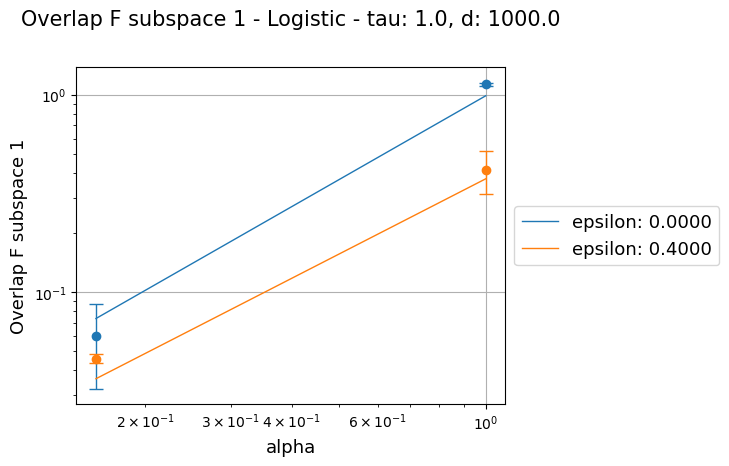

In [111]:
overlaps = ["m","Q","A","N","P","F"]

# check if data_model has attribute feature_sizes
if hasattr(data_model, "feature_sizes"):
    feature_sizes = data_model.feature_sizes
    nr_subspaces = len(feature_sizes)
else:
    nr_subspaces = 1

for overlap in overlaps:
    for i in range(nr_subspaces):
        create_plot(df, f"Overlap {overlap} subspace {i}", f"{overlap}_{i}_state_evolution",f"{overlap}_{i}_erm")
